In [1]:
from IPython.display import Image
Image(url= "https://images3.alphacoders.com/788/thumb-1920-78899.jpg")

# <center><h1><font color='blue'>Team H - FIFA Social Network Analysis</font> </center></h1>

* Andrés Ayala                                
* Cesar Daniel Bolfeta
* Federico Chiari
* Marianina Gutierrez
* Nicolás Ortiz Freuler
* Raquel Ordoñez
* Rebbecah Cohen
* Tsitsino Dalakishvili

 ## <center>Introduction: FIFA 21 Social Network</center>
 
For this group assignment, we decided to study the relationships within futbol and extract insights from those relationships. Using the FIFA Kaggle datasets(https://www.kaggle.com/stefanoleone992/fifa-21-complete-player-dataset?select=players_15.csv), we decided to explore the movements in this passionate game. 

From the data available we intend to explore the existance (or not) of trends and patterns in the FIFA world: do players from Argentina usually get transfered to a particular country? How interconnected are the different clubs? Does a particular league host more international players? 

In a world where a player itself can be valued as much as a unicorn, understanding the patterns within this network can provide interesting insights.

#### Libraries that will be used:

In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from igraph import *
import cairo


import warnings
warnings.filterwarnings('ignore')

### Loading the data

In [3]:
# Our primary data will be the Fifa 21
f21 = pd.read_csv('C:\\Users\\nicol\\OneDrive\\Escritorio\\IE\\MBD II\\Term 2\\Social Networks\\players_21.csv', index_col='sofifa_id')

In [4]:
# Data from Fifa 20 to Fifa 15 will be included to add depth to the analysis and connections among the players 

f20 = pd.read_csv('C:\\Users\\nicol\\OneDrive\\Escritorio\\IE\\MBD II\\Term 2\\Social Networks\\players_20.csv', index_col='sofifa_id')
f19 = pd.read_csv('C:\\Users\\nicol\\OneDrive\\Escritorio\\IE\\MBD II\\Term 2\\Social Networks\\players_19.csv', index_col='sofifa_id')
f18 = pd.read_csv('C:\\Users\\nicol\\OneDrive\\Escritorio\\IE\\MBD II\\Term 2\\Social Networks\\players_18.csv', index_col='sofifa_id')
f17 = pd.read_csv('C:\\Users\\nicol\\OneDrive\\Escritorio\\IE\\MBD II\\Term 2\\Social Networks\\players_17.csv', index_col='sofifa_id')
f16 = pd.read_csv('C:\\Users\\nicol\\OneDrive\\Escritorio\\IE\\MBD II\\Term 2\\Social Networks\\players_16.csv', index_col='sofifa_id')
f15 = pd.read_csv('C:\\Users\\nicol\\OneDrive\\Escritorio\\IE\\MBD II\\Term 2\\Social Networks\\players_15.csv', index_col='sofifa_id')

In [5]:
# Validating that the different datasets have similar shapes and columns

datasets = [f21, f20, f19, f18, f17, f16, f15]

for data in datasets:
    print(data.shape)

print()    
print('Is the shape of columns the same?', (f21.columns==f15.columns).sum())

(18944, 105)
(18483, 105)
(18085, 105)
(17954, 105)
(17597, 105)
(15623, 105)
(16155, 105)

Is the shape of columns the same? 105


### <center>Data Preprocessing </center>

To proceed with the analysis we will need to select a subset of the data available to make the corresponding analysis

In [6]:
cols = []
for col in f21.columns:
     cols.append(col)
        
print(cols)

['player_url', 'short_name', 'long_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'powe

In [7]:
print('Number of players in FIFA 2021:', len(f21))

print('Players in National Teams: ', len(f21)-(f21['nation_jersey_number']).isnull().sum())

Number of players in FIFA 2021: 18944
Players in National Teams:  1127


In [8]:
f20.groupby('club_name')['value_eur'].mean().sort_values(ascending=False)

club_name
FC Bayern München    2.994674e+07
Real Madrid          2.717727e+07
FC Barcelona         2.632727e+07
Manchester City      2.562818e+07
Juventus             2.228712e+07
                         ...     
Sligo Rovers         1.752381e+05
Crewe Alexandra      1.712000e+05
Waterford FC         1.572500e+05
Finn Harps           1.084000e+05
UCD AFC              1.080952e+05
Name: value_eur, Length: 668, dtype: float64

**Adding Boolean Column for National Team Player**

In [9]:
f21['national_team'] = f21['nation_jersey_number'].isnull()

In [10]:
for fifa in datasets:
    fifa['national_team'] = fifa['nation_jersey_number'].isnull()

### <center>Defining the structure that willl be used for the analysis</center>

The FIFA datasets contain a lot of information regarding the player's specific performance on the pitch (at the end of the day its a gaming dataset) which are not part of our core social network analysis. Thus, we will clean the dataset to a semi-final structure so as to then define the Nodes and Edges that we will use.

In [11]:
# Columns that will be used for primary table (FIFA 21)
club_cols = ['short_name', 'age', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'value_eur', 
             'wage_eur','release_clause_eur', 'national_team', 'international_reputation', 'loaned_from', 'joined']

In [12]:
# Columns for previous years

mov_cols = ['short_name', 'age', 'nationality', 'club_name', 'league_name', 'league_rank', 'overall', 'value_eur', 
             'wage_eur','release_clause_eur', 'national_team', 'international_reputation', 'loaned_from', 'joined']

In [13]:
# List with columns new names specifying the year (i.e: club_name20 = club_name for 2020)

year_cols_20 = ['short_name', 'age', 'nationality','club_name20', 'league_name20', 'league_rank20', 'overall20', 'value_eur20', 
             'wage_eur20', 'release_clause_eur20','national_team20', 'international_reputation20', 'loaned_from20', 'joined20']

year_cols_19 = ['short_name', 'age', 'nationality','club_name19', 'league_name19', 'league_rank19', 'overall19', 'value_eur19', 
             'wage_eur19', 'release_clause_eur19','national_team19', 'international_reputation19', 'loaned_from19', 'joined19']


year_cols_18 = ['short_name', 'age', 'nationality','club_name18', 'league_name18', 'league_rank18', 'overall18', 'value_eur18', 
             'wage_eur18', 'release_clause_eur18','national_team18', 'international_reputation18', 'loaned_from18', 'joined18']

year_cols_17 = ['short_name', 'age', 'nationality','club_name17', 'league_name17', 'league_rank17', 'overall17', 'value_eur17', 
             'wage_eur17', 'release_clause_eur17', 'national_team17', 'international_reputation17', 'loaned_from17', 'joined17']

year_cols_16 = ['short_name', 'age', 'nationality','club_name16', 'league_name16', 'league_rank16', 'overall16', 'value_eur16', 
             'wage_eur16', 'release_clause_eur16', 'national_team16', 'international_reputation16', 'loaned_from16', 'joined16']

year_cols_15 = ['short_name', 'age', 'nationality','club_name15', 'league_name15', 'league_rank15', 'overall15', 'value_eur15', 
             'wage_eur15', 'release_clause_eur15', 'national_team15', 'international_reputation15', 'loaned_from15', 'joined15']

In [14]:
# Subset of the data for FIFA 2021
clubs_21 = f21[f21.columns.intersection(club_cols)]

In [15]:
# Subset of data for previous years
clubs_20 = f20[f20.columns.intersection(mov_cols)]
clubs_19 = f19[f19.columns.intersection(mov_cols)]
clubs_18 = f18[f18.columns.intersection(mov_cols)]
clubs_17 = f17[f17.columns.intersection(mov_cols)]
clubs_16 = f16[f16.columns.intersection(mov_cols)]
clubs_15 = f15[f15.columns.intersection(mov_cols)]

In [16]:
# Renaming the different columns per year to collapse all data without losing information

clubs_20.rename(columns={i:j for i,j in zip(mov_cols,year_cols_20)}, inplace=True)
clubs_19.rename(columns={i:j for i,j in zip(mov_cols,year_cols_19)}, inplace=True)
clubs_18.rename(columns={i:j for i,j in zip(mov_cols,year_cols_18)}, inplace=True)
clubs_17.rename(columns={i:j for i,j in zip(mov_cols,year_cols_17)}, inplace=True)
clubs_16.rename(columns={i:j for i,j in zip(mov_cols,year_cols_16)}, inplace=True)
clubs_15.rename(columns={i:j for i,j in zip(mov_cols,year_cols_15)}, inplace=True)

In [17]:
print(clubs_21.shape)
print(clubs_20.shape)

(18944, 14)
(18483, 14)


### Stacking the Data into one unique table

By stacking the data we ensure not to lose information and - while many players might have retired (creating subsequent null values) - this information can also be valuable if encoded to see if there is a trend as to where players usually go and play when retiring. 

In [18]:
df_fifa = pd.concat([clubs_21, clubs_20], axis=1)
df_fifa = pd.concat([df_fifa, clubs_19], axis=1)
df_fifa = pd.concat([df_fifa, clubs_18], axis=1)
df_fifa = pd.concat([df_fifa, clubs_17], axis=1)
df_fifa = pd.concat([df_fifa, clubs_16], axis=1)
df_fifa = pd.concat([df_fifa, clubs_15], axis=1)

In [19]:
# The NaN values correspond to retired players - who are no longer in the game and/or team
# Usually, players with lower index number are "older" in the game and will have more NaN's
 
df_fifa.head(2)

short_name  age nationality club_name league_name  league_rank  \
sofifa_id                                                                  
2                NaN  NaN         NaN       NaN         NaN          NaN   
11               NaN  NaN         NaN       NaN         NaN          NaN   

           overall  value_eur  wage_eur  international_reputation  ...  \
sofifa_id                                                          ...   
2              NaN        NaN       NaN                       NaN  ...   
11             NaN        NaN       NaN                       NaN  ...   

             league_name15 league_rank15 overall15 value_eur15 wage_eur15  \
sofifa_id                                                                   
2          Italian Serie A           1.0      68.0    675000.0     9000.0   
11          French Ligue 1           1.0      68.0    675000.0     8000.0   

           international_reputation15 release_clause_eur15 loaned_from15  \
sofifa_id                                                                  
2                                 2.0                  NaN           NaN   
11                                1.0                  NaN           NaN   

             joined15  national_team15  
sofifa_id                               
2          2008-07-01             True  
11         2013-07-01             True  

[2 rows x 98 columns]

In [20]:
len(df_fifa)

41533

In [21]:
player_names = df_fifa['short_name'].dropna()

player_names = player_names.iloc[:,0]

player_names = player_names.to_frame()

In [22]:
df_fifa.shape

(41533, 98)

In [23]:
# Checking for the retirement hypothesis

clubs_15.loc[clubs_15['club_name15']=='LA Galaxy']

short_name  age          nationality club_name15  \
sofifa_id                                                         
330              R. Keane   33  Republic of Ireland   LA Galaxy   
7743           L. Donovan   32        United States   LA Galaxy   
197838            Juninho   25               Brazil   LA Galaxy   
190560        O. Gonzalez   25        United States   LA Galaxy   
193223     Marcelo Sarvas   32               Brazil   LA Galaxy   
212478          G. Zardes   22        United States   LA Galaxy   
174745          J. Penedo   32               Panama   LA Galaxy   
10466         S. Ishizaki   32               Sweden   LA Galaxy   
190883       A. DeLaGarza   26                 Guam   LA Galaxy   
155267          R. Friend   33               Canada   LA Galaxy   
207629       J. Villareal   20        United States   LA Galaxy   
179652          R. Rogers   27        United States   LA Galaxy   
138295        T. Dunivant   33        United States   LA Galaxy   
164542          A. Gordon   32        United States   LA Galaxy   
164587          D. Gargan   31        United States   LA Galaxy   
207672           T. Meyer   24        United States   LA Galaxy   
190568         A. Hušidić   27   Bosnia Herzegovina   LA Galaxy   
164613           J. Riley   31        United States   LA Galaxy   
210711            B. Rowe   25        United States   LA Galaxy   
197912            B. Perk   24        United States   LA Galaxy   
206663         C. Hoffman   23        United States   LA Galaxy   
207674          K. Walker   25        United States   LA Galaxy   
207967          R. Garcia   25        United States   LA Galaxy   
197839           Leonardo   26               Brazil   LA Galaxy   
212827            C. Rugg   23        United States   LA Galaxy   
212414           O. Sorto   19        United States   LA Galaxy   
222078     B. Jamieson IV   17        United States   LA Galaxy   
222082        R. Mendiola   20               Mexico   LA Galaxy   

                     league_name15  league_rank15  overall15  value_eur15  \
sofifa_id                                                                   
330        USA Major League Soccer            1.0         79      5000000   
7743       USA Major League Soccer            1.0         79      5500000   
197838     USA Major League Soccer            1.0         74      3800000   
190560     USA Major League Soccer            1.0         73      2400000   
193223     USA Major League Soccer            1.0         72      1800000   
212478     USA Major League Soccer            1.0         71      1500000   
174745     USA Major League Soccer            1.0         71      1300000   
10466      USA Major League Soccer            1.0         70      1100000   
190883     USA Major League Soccer            1.0         68       975000   
155267     USA Major League Soccer            1.0         65       350000   
207629     USA Major League Soccer            1.0         64       500000   
179652     USA Major League Soccer            1.0         64       475000   
138295     USA Major League Soccer            1.0         64       230000   
164542     USA Major League Soccer            1.0         64       425000   
164587     USA Major League Soccer            1.0         64       325000   
207672     USA Major League Soccer            1.0         63       300000   
190568     USA Major League Soccer            1.0         63       350000   
164613     USA Major League Soccer            1.0         63       210000   
210711     USA Major League Soccer            1.0         62       325000   
197912     USA Major League Soccer            1.0         62       300000   
206663     USA Major League Soccer            1.0         61       230000   
207674     USA Major League Soccer            1.0         61       200000   
207967     USA Major League Soccer            1.0         60       200000   
197839     USA Major League Soccer            1.0         60       220000   
21

The data was correctly stacked providing a set of 41,533 players and 91 variables to use for the vertex and edge definition. 

---

# <center>Defining the Vertices and Edges for the Analysis</center>

As mentioned in the introduction, we will use the clubs as the nodes for our study while the players will provide the edges, showing the movement from the different leagues (and division) that exists in the futbol community. 

### Building the Nodes Table

For the nodes we will focus on the Clubs themselves and look into specific information that will help us undestand the logic of the results we discover

In [24]:
# Aggregated data per club per year:

g21 = clubs_21.groupby('club_name').agg({
    'league_name': 'unique',
    'short_name':'size',
    'age': 'mean',
    'league_rank':'min',
    'overall': 'mean', 
    'value_eur': 'sum',
    'wage_eur': 'sum',
    'nationality': ', '.join,
    'international_reputation': 'sum'
})


g20 = clubs_20.groupby('club_name20').agg({
    'league_name20': 'unique',
    'short_name':'size',
    'age': 'mean',
    'league_rank20':'min',
    'overall20': 'mean', 
    'value_eur20': 'sum',
    'wage_eur20': 'sum',
    'nationality': ', '.join,
    'international_reputation20': 'sum'
})

g19 = clubs_19.groupby('club_name19').agg({
    'league_name19': 'unique',
    'short_name':'size',
    'age': 'mean',
    'league_rank19':'min',
    'overall19': 'mean', 
    'value_eur19': 'sum',
    'wage_eur19': 'sum',
    'nationality': ', '.join,
    'international_reputation19': 'sum'
})


g18 = clubs_18.groupby('club_name18').agg({
    'league_name18': 'unique',
    'short_name':'size',
    'age': 'mean',
    'league_rank18':'min',
    'overall18': 'mean', 
    'value_eur18': 'sum',
    'wage_eur18': 'sum',
    'nationality': ', '.join,
    'international_reputation18': 'sum'
})

g17 = clubs_17.groupby('club_name17').agg({
    'league_name17': 'unique',
    'short_name':'size',
    'age': 'mean',
    'league_rank17':'min',
    'overall17': 'mean', 
    'value_eur17': 'sum',
    'wage_eur17': 'sum',
    'nationality': ', '.join,
    'international_reputation17': 'sum'
})

g16 = clubs_16.groupby('club_name16').agg({
    'league_name16': 'unique',
    'short_name':'size',
    'age': 'mean',
    'league_rank16':'min',
    'overall16': 'mean', 
    'value_eur16': 'sum',
    'wage_eur16': 'sum',
    'nationality': ', '.join,
    'international_reputation16': 'sum'
})

g15 = clubs_15.groupby('club_name15').agg({
    'league_name15': 'unique',
    'short_name':'size',
    'age': 'mean',
    'league_rank15':'min',
    'overall15': 'mean', 
    'value_eur15': 'sum',
    'wage_eur15': 'sum',
    'nationality': ', '.join,
    'international_reputation15': 'sum'
})

## Cleaning the Data

Since FIFA changes the name of certain clubs or invents other clubs due to different reasons. In order to correctly match the different transfers correctly - this data should be cleaned, identifying those clubs. In our case, we decided to drop those teams and focus only on those that are consistent across all FIFA games.

In [25]:
clubs = [g21, g20, g19, g18, g17, g16, g15]

for club in clubs:
    club.reset_index(inplace=True)

In [26]:
#Removing Brackets
g21['league_name'] = g21['league_name'].str[0]
g20['league_name20'] = g20['league_name20'].str[0]
g19['league_name19'] = g19['league_name19'].str[0]
g18['league_name18'] = g18['league_name18'].str[0]
g17['league_name17'] = g17['league_name17'].str[0]
g16['league_name16'] = g16['league_name16'].str[0]
g15['league_name15'] = g15['league_name15'].str[0]

In [27]:
# Extracting the country for the club the player is associated with (or an approximation)

g15['country'] = g15['league_name15'].str.split(' ').str[0]
g16['country'] = g16['league_name16'].str.split(' ').str[0]
g17['country'] = g17['league_name17'].str.split(' ').str[0]
g18['country'] = g18['league_name18'].str.split(' ').str[0]
g19['country'] = g19['league_name19'].str.split(' ').str[0]
g20['country'] = g20['league_name20'].str.split(' ').str[0]
g21['country'] = g21['league_name'].str.split(' ').str[0]

In [28]:
# Checking countries
p = []
for pais in g19['country']:
    if pais not in p:
        p.append(pais)
print(p)

['German', 'French', 'Danish', 'Spanish', 'Holland', 'Greek', 'English', 'Swedish', 'Scottish', 'Australian', 'Turkish', 'Saudi', 'Colombian', 'Campeonato', 'Argentina', 'Polish', 'Italian', 'Spain', 'USA', 'Chilian', 'Swiss', 'Chinese', 'Portuguese', 'Rep.', 'Japanese', 'Mexican', 'Belgian', 'Korean', 'Croatian', 'Ukrainian', 'Austrian', 'Norwegian', 'Finnish', 'South', 'Russian', 'Czech']


In [29]:
# Checking country name
g18[g18['country'].str.contains("Rep.")]

club_name18                   league_name18  short_name  \
84              Bohemian FC  Rep. Ireland Airtricity League          25   
92           Bray Wanderers  Rep. Ireland Airtricity League          21   
163               Cork City  Rep. Ireland Airtricity League          23   
189              Derry City  Rep. Ireland Airtricity League          23   
194         Drogheda United  Rep. Ireland Airtricity League          25   
195                 Dundalk  Rep. Ireland Airtricity League          23   
260              Finn Harps  Rep. Ireland Airtricity League          25   
274           Galway United  Rep. Ireland Airtricity League          25   
362             Limerick FC  Rep. Ireland Airtricity League          22   
534         Shamrock Rovers  Rep. Ireland Airtricity League          25   
542            Sligo Rovers  Rep. Ireland Airtricity League          25   
558  St. Patrick's Athletic  Rep. Ireland Airtricity League          25   

           age  league_rank18  overall18  value_eur18  wage_eur18  \
84   23.000000            1.0  55.760000      3155000       13500   
92   26.238095            1.0  56.238095      2355000       12000   
163  24.608696            1.0  57.086957      4375000       20000   
189  22.869565            1.0  56.608696      4355000       16500   
194  23.280000            1.0  54.760000      2470000       13500   
195  25.086957            1.0  59.347826      6415000       23500   
260  23.640000            1.0  55.200000      2925000       13500   
274  22.040000            1.0  54.040000      2800000       12500   
362  24.272727            1.0  55.636364      2415000       12000   
534  23.240000            1.0  56.880000      5490000       20500   
542  23.120000            1.0  56.080000      3765000       14000   
558  26.440000            1.0  58.560000      4993000       21000   

                                           nationality  \
84   Republic of Ireland, Republic of Ireland, Repu...   
92   Republic of Ireland, Republic of Ireland, Repu...   
163  Republic of Ireland, Republic of Ireland, Repu...   
189  Republic of Ireland, Republic of Ireland, Repu...   
194  Republic of Ireland, Republic of Ireland, Repu...   
195  Northern Ireland, Republic of Ireland, Republi...   
260  Northern Ireland, Republic of Ireland, England...   
274  Republic of Ireland, Republic of Ireland, Keny...   
362  Republic of Ireland, Republic of Ireland, Fran...   
534  Republic of Ireland, Republic of Ireland, Repu...   
542  Scotland, Republic of Ireland, Republic of Ire...   
558  Republic of Ireland, Republic of Ireland, Repu...   

     international_reputation18 country  
84                           25    Rep.  
92                           21    Rep.  
163                          23    Rep.  
189                          23    Rep.  
194                          25    Rep.  
195                          23    Rep.  
260                          25    Rep.  
274                          25    Rep.  
362                          22    Rep.  
534                          25    Rep.  
542                          25    Rep.  
558                          25    Rep.

In [30]:
# Renaming the countries for future correct use: 

nod = [g21, g20, g19, g18, g17, g16, g15]

for data in nod:
    data = data['country'].replace({
        'Argentinian': 'Argentina',
        'Paraguayan': 'Paraguay',
        'Campeonato': 'Brazil',
        'Liga': 'Bolivia',
        'Peruvian': 'Peru',
        'Uruguayan': 'Uruguay',
        'Finnish': 'Finland',
        'UAE': 'United Arab Emirates',
        'Croatian': 'Croatia',
        'Australian': ' Australia',
        'Romanian': 'Romania',
        'Ecuadorian': 'Ecuador',
        'Holland': 'Netherlands',
        'Czech': 'Czech Republic',
        'Chinese': 'China',
        'Japanese': 'Japan',
        'German': 'Germany',
        'French': 'France',
        'Chilian': 'Chile',
        'Spanish': 'Spain',
        'English': 'England',
        'Swedish': 'Sweden',
        'Danish': 'Denmark',
        'Norwegian': 'Norway',
        'Scottish': 'Scotland',
        'Australian': 'Australia',
        'Turkish': 'Turkey',
        'Saudi': 'Saudi Arabia',
        'Colombian': 'Colombia',
        'Russian': 'Russia',
        'Portuguese': 'Portugal',
        'Italian': 'Italy',
        'Rep.': 'Ireland',
        'Swiss': 'Switzerland',
        'Korean': 'South Korea',
        'Mexican': 'Mexico',
        'Belgian': 'Belgium',
        'Polish': 'Poland',
        'Austrian': 'Austria',
        'South': 'South Africa',
        'Greek': 'Greece',
        'Ukrainian': 'Ukraine',
        'Venezuelan': 'Venezuela'
    }, inplace=True)

In [31]:
#Renaming the short_name as num_players to correctly display the information of the column
for data in nod:
    data.rename(columns={'short_name': 'num_players'}, inplace=True)

In [32]:
len(g20)<len(g21)

True

In [33]:
len(g20)

668

**Bias Alert**

Since the transfers have to go from a registered club to another registered club - we notice that the number of clubs slightly increases year over year, which could magnify the amount of transfers.

### <center>Building the Edges Table:</center>

In [34]:
# Filtering Edge Columns

edge_cols = ['short_name', 'club_name', 'league_rank', 'club_name20', 'league_rank20', 'club_name19', 'league_rank19',
             'club_name18', 'league_rank18', 'club_name17', 'league_rank17', 'club_name16', 'league_rank16', 'club_name15',
            'league_rank15', 'league_name15', 'league_name16', 'league_name17', 'league_name18', 'league_name19', 
             'league_name20','league_name']

In [35]:
#Creating an edges dataframe

df_edges = df_fifa[df_fifa.columns.intersection(edge_cols)]

In [36]:
df_edges

short_name short_name   short_name    short_name  \
sofifa_id                                                           
2                       NaN        NaN          NaN           NaN   
11                      NaN        NaN          NaN           NaN   
16                      NaN        NaN  Luis García   Luis García   
27                      NaN        NaN          NaN           NaN   
28                      NaN        NaN          NaN  Manu Herrera   
...                     ...        ...          ...           ...   
258953          I. Niskanen        NaN          NaN           NaN   
258954             R. Ortíz        NaN          NaN           NaN   
258958          O. Filippov        NaN          NaN           NaN   
258968     J. van der Avert        NaN          NaN           NaN   
258970               Astals        NaN          NaN           NaN   

             short_name    short_name    short_name                club_name  \
sofifa_id                                                                      
2                   NaN   G. Pasquale   G. Pasquale                      NaN   
11                  NaN           NaN     R. Rocchi                      NaN   
16          Luis García           NaN           NaN                      NaN   
27                  NaN       J. Cole       J. Cole                      NaN   
28         Manu Herrera  Manu Herrera  Manu Herrera                      NaN   
...                 ...           ...           ...                      ...   
258953              NaN           NaN           NaN         FC Ingolstadt 04   
258954              NaN           NaN           NaN  Estudiantes de La Plata   
258958              NaN           NaN           NaN        Sint-Truidense VV   
258968              NaN           NaN           NaN                Willem II   
258970              NaN           NaN           NaN           CE Sabadell FC   

                          league_name  league_rank  ...        short_name  \
sofifa_id                                           ...                     
2                                 NaN          NaN  ...               NaN   
11                                NaN          NaN  ...               NaN   
16                                NaN          NaN  ...               NaN   
27                                NaN          NaN  ...               NaN   
28                                NaN          NaN  ...               NaN   
...                               ...          ...  ...               ...   
258953           German 3. Bundesliga          3.0  ...       I. Niskanen   
258954     Argentina Primera División          1.0  ...          R. Ortíz   
258958     Belgian Jupiler Pro League          1.0  ...       O. Filippov   
258968             Holland Eredivisie          1.0  ...  J. van der Avert   
258970       Spanish Segunda División          2.0  ...            Astals   

          short_name   short_name    short_name    short_name    short_name  \
sofifa_id                                                                     
2                NaN          NaN           NaN           NaN   G. Pasquale   
11               NaN          NaN           NaN           NaN           NaN   
16               NaN  Luis García   Luis García   Luis García           NaN   
27               NaN          NaN           NaN           NaN       J. Cole   
28               NaN          NaN  Manu Herrera  Manu Herrera  Manu Herrera   
...              ...          ...           ...           ...           ...   
258953           NaN          NaN           NaN           NaN           NaN   
258954           NaN          NaN           NaN           NaN           NaN   
258958           NaN          NaN           NaN           NaN           NaN   
258968           NaN          NaN           NaN           NaN           NaN   
258970           NaN          NaN           NaN           NaN           NaN   

             short_name  club_name15           l

In [37]:
# We will first make an evaluation discarding retired/starting players

df_edges.dropna(inplace=True)

**Idea**

Starting from 2015 - our first Fifa dataset - we will see how the initial setup will change once the market opens and transfers, retirements and new players surge in futbol. This dynamic will be sustained until 2021 (our last dataset). 

In [38]:
# Building movements among players:

edges16 = df_edges.copy()[[]]
edges16['From'] = df_edges['club_name15']
edges16['To'] = df_edges['club_name16']
edges16['weight'] = df_edges['league_rank16']
edges16['From league'] = df_edges['league_name15']
edges16['To league'] = df_edges['league_name16']
edges16 = edges16.merge(player_names, left_index=True, right_index=True)
edges16.set_index('short_name', inplace=True)



edges17 = df_edges.copy()[[]]
edges17['From'] = df_edges['club_name16']
edges17['To'] = df_edges['club_name17']
edges17['weight'] = df_edges['league_rank17']
edges17['From league'] = df_edges['league_name16']
edges17['To league'] = df_edges['league_name17']
edges17 = edges17.merge(player_names, left_index=True, right_index=True)
edges17.set_index('short_name', inplace=True)

edges18 = df_edges.copy()[[]]
edges18['From'] = df_edges['club_name17']
edges18['To'] = df_edges['club_name18']
edges18['weight'] = df_edges['league_rank18']
edges18['From league'] = df_edges['league_name17']
edges18['To league'] = df_edges['league_name18']
edges18 = edges18.merge(player_names, left_index=True, right_index=True)
edges18.set_index('short_name', inplace=True)

edges19 = df_edges.copy()[[]]
edges19['From'] = df_edges['club_name18']
edges19['To'] = df_edges['club_name19']
edges19['weight'] = df_edges['league_rank19']
edges19['From league'] = df_edges['league_name18']
edges19['To league'] = df_edges['league_name19']
edges19 = edges19.merge(player_names, left_index=True, right_index=True)
edges19.set_index('short_name', inplace=True)

edges20 = df_edges.copy()[[]]
edges20['From'] = df_edges['club_name19']
edges20['To'] = df_edges['club_name20']
edges20['weight'] = df_edges['league_rank20']
edges20['From league'] = df_edges['league_name19']
edges20['To league'] = df_edges['league_name20']
edges20 = edges20.merge(player_names, left_index=True, right_index=True)
edges20.set_index('short_name', inplace=True)

edges21 = df_edges.copy()[[]]
edges21['From'] = df_edges['club_name20']
edges21['To'] = df_edges['club_name']
edges21['weight'] = df_edges['league_rank']
edges21['From league'] = df_edges['league_name20']
edges21['To league'] = df_edges['league_name']
edges21 = edges21.merge(player_names, left_index=True, right_index=True)
edges21.set_index('short_name', inplace=True)

In [39]:
# Creating a unique edges table with all the clubs that players had for previous 5 years (or remained)

edges = edges21.append(edges20)
edges = edges.append(edges19)
edges = edges.append(edges18)
edges = edges.append(edges17)
edges = edges.append(edges16)

In [40]:
# Players that retired/started playing during the process

print('Not Null Values: ') 
print(edges.notnull().sum())

print('*'*25)

print('Null Values: ') 
print(edges.isnull().sum())

Not Null Values: 
From           23712
To             23712
weight         23712
From league    23712
To league      23712
dtype: int64
*************************
Null Values: 
From           0
To             0
weight         0
From league    0
To league      0
dtype: int64


In [41]:
# Removing non-transfers:

edges16 = edges16[[x != y for x, y in zip(edges16['From'], edges16['To'])]]
edges17 = edges17[[x != y for x, y in zip(edges17['From'], edges17['To'])]]
edges18 = edges18[[x != y for x, y in zip(edges18['From'], edges18['To'])]]
edges19 = edges19[[x != y for x, y in zip(edges19['From'], edges19['To'])]]
edges20 = edges20[[x != y for x, y in zip(edges20['From'], edges20['To'])]]
edges21 = edges21[[x != y for x, y in zip(edges21['From'], edges21['To'])]]

**Weights**

In social Networks, weights capture the relative intensity of the relationship between actors (in other words, their relative proximity). In futbol, this proximity between clubs is mostly captured by clubs playing the same league and also same divison (which facilitates international interconnections due to competitions, or a higher probability of a player participating in the national team). 

Thus we decided to assign a weight of 4 for transfers occuring within the same league and, then add a weigth of 2 if the player is from a top league, and 1 if the player is from a second-tier league. 

In [42]:
#Adjusting the Weight so that ranking of the league

edges16['weight'] = edges16['weight'].replace({1:4, 2:3, 3:3, 4:1})
edges17['weight'] = edges17['weight'].replace({1:4, 2:3, 3:3, 4:1})
edges18['weight'] = edges18['weight'].replace({1:4, 2:3, 3:3, 4:1})
edges19['weight'] = edges19['weight'].replace({1:4, 2:3, 3:3, 4:1})
edges20['weight'] = edges20['weight'].replace({1:4, 2:3, 3:3, 4:1})
edges21['weight'] = edges21['weight'].replace({1:4, 2:3, 3:3, 4:1})

In [43]:
# Creating a boolean column to determine if the league is the same

edges16['same'] = edges16['From league'] == edges16['To league']
edges17['same'] = edges17['From league'] == edges17['To league']
edges18['same'] = edges18['From league'] == edges18['To league']
edges19['same'] = edges19['From league'] == edges19['To league']
edges20['same'] = edges20['From league'] == edges20['To league']
edges21['same'] = edges21['From league'] == edges21['To league']

In [44]:
edges16['same'] = edges16['same'].replace({True:4, False:0})
edges17['same'] = edges17['same'].replace({True:4, False:0})
edges18['same'] = edges18['same'].replace({True:4, False:0})
edges19['same'] = edges19['same'].replace({True:4, False:0})
edges20['same'] = edges20['same'].replace({True:4, False:0})
edges21['same'] = edges21['same'].replace({True:4, False:0})

In [45]:
# Adding the columns:

edges16['weight'] = edges16['weight'] + edges16['same']
edges17['weight'] = edges17['weight'] + edges17['same']
edges18['weight'] = edges18['weight'] + edges18['same']
edges19['weight'] = edges19['weight'] + edges19['same']
edges20['weight'] = edges20['weight'] + edges20['same']
edges21['weight'] = edges21['weight'] + edges21['same']

In [46]:
edge = [edges16, edges17, edges18, edges19, edges20, edges21]

for ed in edge:
    ed.drop(['From league', 'To league', 'same'], axis=1, inplace=True)

### Cleaning the Edges to avoid Graph mismatch

In [47]:
# Filter data so that club in 2016 existed in 2015 and remove when it is not the case
edges16 = edges16.loc[(edges16['From'].isin(g16['club_name16']))]
edges16 = edges16.loc[(edges16['To'].isin(g16['club_name16']))]

edges17 = edges17.loc[(edges17['From'].isin(g17['club_name17']))]
edges17 = edges17.loc[(edges17['To'].isin(g17['club_name17']))]


edges18 = edges18.loc[(edges18['From'].isin(g18['club_name18']))]
edges18 = edges18.loc[(edges18['To'].isin(g18['club_name18']))]


edges19 = edges19.loc[(edges19['From'].isin(g19['club_name19']))]
edges19 = edges19.loc[(edges19['To'].isin(g19['club_name19']))]


edges20 = edges20.loc[(edges20['From'].isin(g20['club_name20']))]
edges20 = edges20.loc[(edges20['To'].isin(g20['club_name20']))]


edges21 = edges21.loc[(edges21['From'].isin(g21['club_name']))]
edges21 = edges21.loc[(edges21['To'].isin(g21['club_name']))]

In [48]:
len(edges16)

1288

### Downloading the data to use in Gephi

In [49]:
# Saving Edges
edges16.to_csv('edges16.csv')
edges17.to_csv('edges17.csv')
edges18.to_csv('edges18.csv')
edges19.to_csv('edges19.csv')
edges20.to_csv('edges20.csv')
edges21.to_csv('edges21.csv')

In [50]:
# Saving nodes
g15.to_csv('g15.csv')
g16.to_csv('g16.csv')
g17.to_csv('g17.csv')
g18.to_csv('g18.csv')
g19.to_csv('g19.csv')
g20.to_csv('g20.csv')
g21.to_csv('g21.csv')

# <center><font color = green>Network Analysis FIFA 2016</font></center>


In this segment we will define our primary analysis - where we will establish the number of nodes, edges in our graph - along with the directed aspect and other descriptive measures for the data. 

**Defining the Vertex and Nodes**

In [51]:
g_data16 = Graph.DataFrame(edges=edges16, vertices=g16, directed=True, use_vids=False)

In [52]:
summary(g_data16)

IGRAPH DNW- 589 1288 -- 
+ attr: age (v), country (v), international_reputation16 (v), league_name16 (v), league_rank16 (v), name (v), nationality (v), num_players (v), overall16 (v), value_eur16 (v), wage_eur16 (v), weight (e)


**Observation**

As the summary indicates, we have created a Directed Named and Weighted graph where we have 538 nodes and 1202 edges for the 2016 futbol transfer market. This result is consistent with our build-up of the model - confirming that the data was correctly integrated into the Graph Object in Igraph.

### <center>Network Properties</center>

The first step of the analisis will consist of looking in to the 2016 network properties such as the path length, diameter, along with the degree distribution to understand how the composition looks like.

In [53]:
Graph.average_path_length(g_data16)

5.960926448491956

In [54]:
# Nodes with maximum distribution:
print("The maximum degree distribution is: ", Graph.maxdegree(g_data16))

The maximum degree distribution is:  18


In [55]:
print("The minimum degree distribution is: ", np.min(g_data16.vs.degree()))

The minimum degree distribution is:  0


In [56]:
# Measure of the "longest shortest path" with weights:
g_data16.diameter(weights = 'weight')

82.0

In [57]:
len(Graph.get_diameter(g_data16))

16

### <center>Centrality Measures</center>

The centrality in social network analysis will provide a glimpse on different measures to understand the important nodes in a graph.

In [58]:
degree = g_data16.degree()

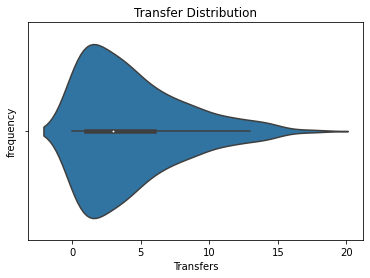

In [59]:
sns.violinplot(degree).set(title='Transfer Distribution', xlabel='Transfers', ylabel='frequency');

In [60]:
v_betweenness = g_data16.vs.betweenness()

In [61]:
v_closeness = g_data16.vs.closeness()

In [62]:
v_harmonic = g_data16.harmonic_centrality(normalized = True)

In [63]:
# Centrality Measures 2016
g16['degree'] = degree
g16['betw'] = v_betweenness
g16['close'] = v_closeness
g16['harmonic'] = v_harmonic

**Degree Observation**

Degrees measures the total number of edges connected to a particular vertex. In this case: the number of out-going and in-going players for a particular club. 

From the degree analysis we can observe that Aston Villa was the team that was the most active in the transfer market with 18 transfers (followed by Granada with 17). This amount of transaction from season to season is not common in futbol and usually occurs when a team loses its category - as many players contracts are binded by a category clause -. Nevertheless, from what we could investigate, this was not the case where the team renewed its plantiff of players by transfering 10 players and acquiring 8.

In [64]:
g16.sort_values(by='degree', ascending=False).head(3)

club_name16           league_name16  num_players        age  \
46   Aston Villa  English Premier League           30  25.066667   
258   Granada CF  Spain Primera Division           30  24.066667   
454  SC Freiburg    German 2. Bundesliga           27  23.407407   

     league_rank16  overall16  value_eur16  wage_eur16  \
46             1.0  72.600000    114925000     1013000   
258            1.0  70.733333     78050000      764000   
454            2.0  66.370370     32770000      330000   

                                           nationality  \
46   England, United States, Denmark, Republic of I...   
258  Spain, Spain, Portugal, Brazil, Slovenia, Spai...   
454  Germany, Spain, Italy, Germany, Germany, Bosni...   

     international_reputation16  country  degree         betw     close  \
46                           42  England      18  5561.159185  0.281215   
258                          33    Spain      17  7310.279311  0.292912   
454                          31  Germany      17  9679.544734  0.277162   

     harmonic  
46   0.280452  
258  0.286605  
454  0.273220

In [65]:
edges16.loc[edges16['From']=='Aston Villa']

From                       To  weight
short_name                                                
F. Delph      Aston Villa          Manchester City     8.0
G. Burke      Aston Villa             Notts County     1.0
C. Benteke    Aston Villa                Liverpool     8.0
N. Baker      Aston Villa             Bristol City     3.0
T. Cleverley  Aston Villa                  Everton     8.0
E. Stevens    Aston Villa               Portsmouth     1.0
A. Weimann    Aston Villa             Derby County     3.0
M. Lowton     Aston Villa                  Burnley     3.0
J. Graham     Aston Villa  Wolverhampton Wanderers     3.0
C. Robinson   Aston Villa             Bristol City     3.0

In [66]:
edges16.loc[edges16['To']=='Aston Villa']

From           To  weight
short_name                                              
S. Sinclair         Manchester City  Aston Villa     8.0
José Crespo              Córdoba CF  Aston Villa     4.0
G. Gardner   Brighton & Hove Albion  Aston Villa     4.0
I. Gueye                 LOSC Lille  Aston Villa     4.0
J. Ayew                  FC Lorient  Aston Villa     4.0
J. Veretout               FC Nantes  Aston Villa     4.0
Carles Gil              Valencia CF  Aston Villa     4.0
J. Amavi                   OGC Nice  Aston Villa     4.0

**Betweenness Observation**

Betweenness measures the number of times a node lies in the shortest path between other nodes, which reveals the amount of influence a node has over the flow of information in a graph. 

From the results obtained, we observe that Cardiff City - a small team from the English Championship League - holds the highest betweenness. An explanation for this result would be that Cardiff interacted with different teams and categories in this market window, whereby leading towards positioning itself as the shortest path among the universe of transactions in 2016

In [67]:
g16.sort_values(by='betw', ascending=False).head(3)

club_name16                league_name16  num_players        age  \
108     Cardiff City  English League Championship           26  25.038462   
574   Wigan Athletic           English League One           25  25.680000   
65   Birmingham City  English League Championship           27  24.185185   

     league_rank16  overall16  value_eur16  wage_eur16  \
108            2.0  67.730769     38325000      404000   
574            3.0  65.400000     15675000      179000   
65             2.0  64.925926     18520000      218000   

                                           nationality  \
108  Gabon, Scotland, Brazil, Trinidad & Tobago, En...   
574  Finland, Scotland, England, Republic of Irelan...   
65   Poland, Jamaica, United States, England, Nethe...   

     international_reputation16  country  degree          betw     close  \
108                          30  England      11  11245.522194  0.279018   
574                          27  England      15  10978.697603  0.277316   
65                           30  England      14  10099.404444  0.269397   

     harmonic  
108  0.273558  
574  0.274283  
65   0.265675

In [68]:
edges16.loc[edges16['To']=='Cardiff City']

From            To  weight
short_name                                         
L. Peltier  Huddersfield Town  Cardiff City     7.0
S. O'Keefe     Crystal Palace  Cardiff City     3.0
S. Malone            Millwall  Cardiff City     7.0
J. Mason     Bolton Wanderers  Cardiff City     7.0
S. Ameobi    Newcastle United  Cardiff City     3.0

In [69]:
edges16.loc[edges16['From']=='Cardiff City']

From                       To  weight
short_name                                                   
M. Eikrem       Cardiff City                 Malmö FF     4.0
A. Le Fondre    Cardiff City  Wolverhampton Wanderers     7.0
Juan Cala       Cardiff City                Getafe CF     4.0
J. Brayford     Cardiff City         Sheffield United     3.0
G. Burgstaller  Cardiff City           1. FC Nürnberg     3.0
M. Dæhli        Cardiff City              SC Freiburg     3.0

**Harmonic Closeness Observation**

Since there are clusters of clubs which are not connected - the closeness is not a good metric to measure centrality for 2016. As a result, we will measure how easy the different clubs can spread the information across the futbol grid using the harmonic centrality - which corrects for this issue.

In 2016 Manchester United managed to position itself as a club with a high centrality as it transfered players to several different leagues (Italy, France, Ireland, Neatherlands and Germany) - positioning itself marginally above Granada whom also had an international active presence. 

In [70]:
g16.sort_values(by='harmonic', ascending=False).head(3)

club_name16           league_name16  num_players        age  \
337  Manchester United  English Premier League           27  24.703704   
258         Granada CF  Spain Primera Division           30  24.066667   
46         Aston Villa  English Premier League           30  25.066667   

     league_rank16  overall16  value_eur16  wage_eur16  \
337            1.0  76.259259    366715000     2278000   
258            1.0  70.733333     78050000      764000   
46             1.0  72.600000    114925000     1013000   

                                           nationality  \
337  Spain, England, Germany, Spain, France, Spain,...   
258  Spain, Spain, Portugal, Brazil, Slovenia, Spai...   
46   England, United States, Denmark, Republic of I...   

     international_reputation16  country  degree         betw     close  \
337                          61  England      14  8279.781942  0.293600   
258                          33    Spain      17  7310.279311  0.292912   
46                           42  England      18  5561.159185  0.281215   

     harmonic  
337  0.287945  
258  0.286605  
46   0.280452

In [71]:
edges16.loc[edges16['To']=='Manchester United']

From                 To  weight
short_name                                                
S. Romero             Sampdoria  Manchester United     4.0
M. Schneiderlin     Southampton  Manchester United     8.0
M. Darmian               Torino  Manchester United     4.0
N. Powell        Leicester City  Manchester United     8.0
M. Depay                    PSV  Manchester United     4.0

In [72]:
edges16.loc[edges16['From']=='Manchester United']

From                    To  weight
short_name                                                  
Falcao       Manchester United               Chelsea     8.0
J. Evans     Manchester United  West Bromwich Albion     8.0
B. Amos      Manchester United      Bolton Wanderers     3.0
A. Di María  Manchester United   Paris Saint-Germain     4.0
Rafael       Manchester United    Olympique Lyonnais     4.0
T. Blackett  Manchester United                Celtic     4.0
A. Januzaj   Manchester United     Borussia Dortmund     4.0
R. James     Manchester United        Wigan Athletic     3.0
J. Rothwell  Manchester United              Barnsley     3.0

### <center>Community Detection</center>

To establish the communityies that existed among the different clubs in Fifa for 2015/2016 transfer market we will use the `community_infomap` function from Igraph to understand what type of relationships existed during this period.  

In [73]:
Com_data16=g_data16.community_infomap(edge_weights='weight')

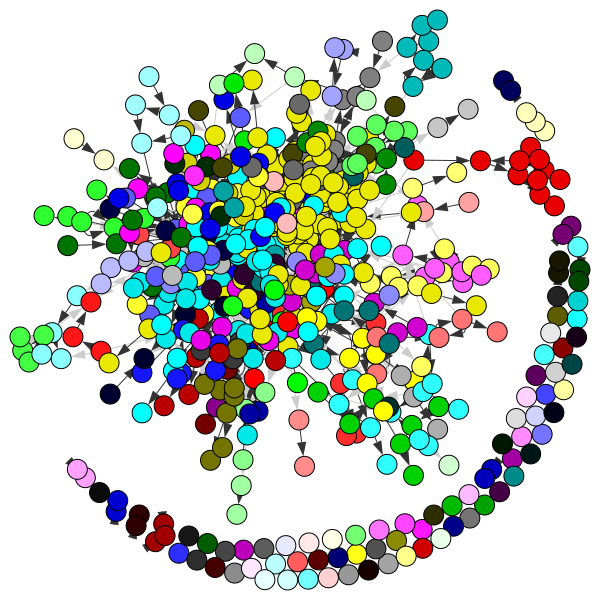

In [74]:
plot(Com_data16)

In [75]:
for club in Com_data16[11][:]:
    print(g_data16.vs[club]['league_name16'],'- Team:',g_data16.vs[club]['name'],'Reputation:',
          g_data16.vs[club]['international_reputation16'])

Danish Superliga - Team: Aalborg BK Reputation: 28
Danish Superliga - Team: FC København Reputation: 33
Turkish Süper Lig - Team: Gençlerbirliği SK Reputation: 26
Swedish Allsvenskan - Team: IFK Göteborg Reputation: 25
Danish Superliga - Team: Odense Boldklub Reputation: 25
Swedish Allsvenskan - Team: Åtvidabergs FF Reputation: 23


In [76]:
labels = []
for club in Com_data16[11][:]:
    labels.append(g_data16.vs[club]['name'])

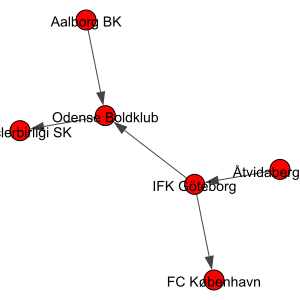

In [77]:
com_16 =Com_data16.subgraph(11)
plot(com_16, vertex_label = labels, bbox=(300, 300))


**Observation**

An Australian futbol connection can be appreciated in this case.

# <center><font color= green>Network Analysis FIFA 2017</font></center>


**Defining the Vertex and Nodes**

In [78]:
g_data17 = Graph.DataFrame(edges=edges17, vertices=g17, directed=True, use_vids=False)

In [79]:
summary(g_data17)

IGRAPH DNW- 632 1416 -- 
+ attr: age (v), country (v), international_reputation17 (v), league_name17 (v), league_rank17 (v), name (v), nationality (v), num_players (v), overall17 (v), value_eur17 (v), wage_eur17 (v), weight (e)


**Observation**

As the summary indicates, we have created a Directed Named and Weighted graph where we have 570 nodes and 1320 edges for the 2017 futbol transfer market

### <center>Network Properties</center>

Reviewing the properties of the 2017 futbol market

In [80]:
Graph.average_path_length(g_data17)

5.878372585977089

In [81]:
# Nodes with maximum distribution:
print("The maximum degree distribution is: ", Graph.maxdegree(g_data17))

The maximum degree distribution is:  23


In [82]:
print("The minimum degree distribution is: ", np.min(g_data17.vs.degree()))

The minimum degree distribution is:  0


In [83]:
# Measure of the "longest shortest path" with weights:
g_data17.diameter(weights = 'weight')

100.0

In [84]:
len(Graph.get_diameter(g_data17))

18

### <center>Centrality Measures</center>

Obtaining information for the 2017 club centrality. Since the closenness provides inconsistent results we will focus on the harmonic centrality instead.

In [85]:
degree = g_data17.degree()

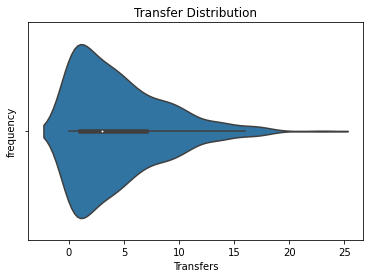

In [86]:
sns.violinplot(degree).set(title='Transfer Distribution', xlabel='Transfers', ylabel='frequency');

In [87]:
v_betweenness = g_data17.vs.betweenness()

In [88]:
v_harmonic = g_data17.harmonic_centrality(normalized = True)

In [89]:
# Centrality Measures 2016
g17['degree'] = degree
g17['betw'] = v_betweenness
g17['harmonic'] = v_harmonic

**Degree Observation**

Interestingly, Granada in 2017 is the club that shows an impressive amount of transfers. In contrast with the 2016 market, we can observe that the club released 10 players and signed 12 others. This amount of transfers is quite hectic to manage and build a consolidated team, which can explain why they performed a poor campaing in 2017 finishing in the last position with only 4 victories. 

In [90]:
g17.sort_values(by='degree', ascending=False).head(3)

club_name17                league_name17  num_players        age  \
283        Granada CF       Spain Primera Division           33  24.151515   
393  Newcastle United  English League Championship           30  24.433333   
501         Sampdoria              Italian Serie A           29  25.310345   

     league_rank17  overall17  value_eur17  wage_eur17  \
283            1.0  71.515152    106850000      439000   
393            2.0  72.133333    111700000      916000   
501            1.0  72.068966    114755000      701000   

                                           nationality  \
283  Mexico, Morocco, Portugal, France, Spain, Spai...   
393  Spain, Ivory Coast, DR Congo, England, Belgium...   
501  Italy, Belgium, Italy, Italy, Italy, Argentina...   

     international_reputation17  country  degree          betw  harmonic  
283                          38    Spain      23   9235.557609  0.286250  
393                          37  England      18  12382.865022  0.285035  
501                          42    Italy      18   9087.119707  0.275511

In [91]:
edges17.loc[edges17['From']=='Granada CF']

From                       To  weight
short_name                                                   
Andrés Fernández  Granada CF            Villarreal CF     8.0
Rochina           Granada CF              Rubin Kazan     4.0
Miguel Lopes      Granada CF     Akhisar Belediyespor     4.0
Rubén Pérez       Granada CF               CD Leganés     8.0
C. Biraghi        Granada CF                  Pescara     4.0
T. Bifouma        Granada CF  Sporting Club de Bastia     4.0
Dória             Granada CF   Olympique de Marseille     4.0
S. Dimitrievski   Granada CF   Gimnàstic de Tarragona     3.0
Rober Ibáñez      Granada CF               CD Leganés     8.0
Edgar Méndez      Granada CF         Deportivo Alavés     8.0
I. Success        Granada CF                  Watford     4.0

In [92]:
edges17.loc[edges17['To']=='Granada CF']

From          To  weight
short_name                                                
G. Ochoa                     Málaga CF  Granada CF     8.0
Oier                     Real Sociedad  Granada CF     8.0
M. Carcela-González         SL Benfica  Granada CF     4.0
M. Saunier                ESTAC Troyes  Granada CF     4.0
Gabriel Silva                    Carpi  Granada CF     4.0
Jon Toral              Birmingham City  Granada CF     4.0
Luís Martins                CA Osasuna  Granada CF     4.0
Sergi Samper              FC Barcelona  Granada CF     8.0
Andreas Pereira      Manchester United  Granada CF     4.0
Rúben Vezo                 Valencia CF  Granada CF     8.0
G. Silva                        Torino  Granada CF     4.0
Pol Llonch                   Girona FC  Granada CF     4.0

**Betweenness Observation**

In 2017 Rosario Central positioned itself as the team with the highest betweenness which is explained by how the argentinean team became a bridge between the latinamerican market and european market (with transaction with Portugal) and, furthermore Argentina and Mexico, This makes for 2017 Rosario Central the team that provides the shortest average path for the transactions. 

In [93]:
g17.sort_values(by='betw', ascending=False).head(3)

club_name17                league_name17  num_players        age  \
474   Rosario Central   Argentina Primera División           30  26.100000   
393  Newcastle United  English League Championship           30  24.433333   
131           Chelsea       English Premier League           33  24.272727   

     league_rank17  overall17  value_eur17  wage_eur17  \
474            1.0  68.600000     54410000      307000   
393            2.0  72.133333    111700000      916000   
131            1.0  75.545455    519475000     3379000   

                                           nationality  \
474  Colombia, Argentina, Argentina, Argentina, Arg...   
393  Spain, Ivory Coast, DR Congo, England, Belgium...   
131  Belgium, Belgium, Spain, Spain, Brazil, Englan...   

     international_reputation17    country  degree          betw  harmonic  
474                          32  Argentina       8  12552.553544  0.236309  
393                          37    England      18  12382.865022  0.285035  
131                          74    England      14  11013.738584  0.280564

In [94]:
edges17.loc[edges17['To']=='Rosario Central']

From               To  weight
short_name                                        
T. Gutiérrez  Sporting CP  Rosario Central     4.0
S. Sosa           Pachuca  Rosario Central     4.0
W. Camacho    Racing Club  Rosario Central     8.0
E. Burgos      Godoy Cruz  Rosario Central     8.0

In [95]:
edges17.loc[edges17['From']=='Rosario Central']

From                      To  weight
short_name                                                   
M. Caranta    Rosario Central  Club Atlético Talleres     8.0
N. Domínguez  Rosario Central               Querétaro     4.0
E. Gómez      Rosario Central      Defensa y Justicia     8.0
F. Cervi      Rosario Central              SL Benfica     4.0

**Harmonic Closeness Observation**

The high degree of Granada is also combined with a strong participation within the European Futbol Community, whereby the club has interactions with many different leagues across Europe - due to the active participation within the transfer market.

In [96]:
g17.sort_values(by='harmonic', ascending=False).head(3)

club_name17                league_name17  num_players        age  \
283        Granada CF       Spain Primera Division           33  24.151515   
458           Reading  English League Championship           30  24.066667   
393  Newcastle United  English League Championship           30  24.433333   

     league_rank17  overall17  value_eur17  wage_eur17  \
283            1.0  71.515152    106850000      439000   
458            2.0  65.533333     28945000      365000   
393            2.0  72.133333    111700000      916000   

                                           nationality  \
283  Mexico, Morocco, Portugal, France, Spain, Spai...   
458  Netherlands, Wales, Netherlands, Jamaica, Repu...   
393  Spain, Ivory Coast, DR Congo, England, Belgium...   

     international_reputation17  country  degree          betw  harmonic  
283                          38    Spain      23   9235.557609  0.286250  
458                          32  England      17  10754.650269  0.285126  
393                          37  England      18  12382.865022  0.285035

### <center>Community Detection</center>

Looking at the communities created in the 2016/17 market.

In [97]:
Com_data17=g_data17.community_infomap(edge_weights='weight')

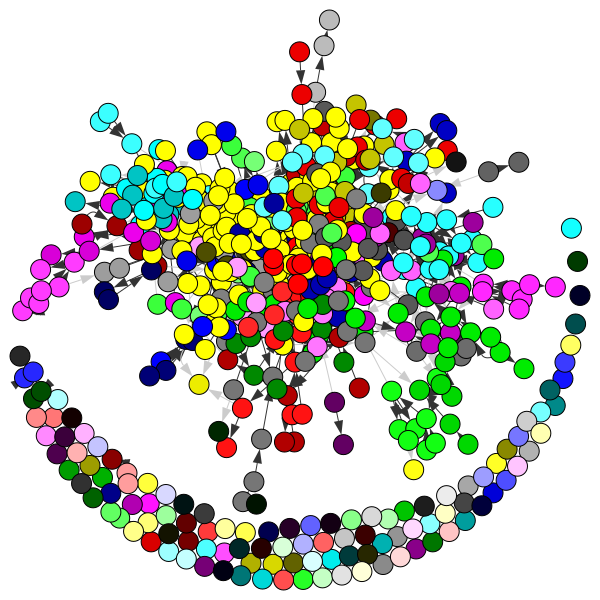

In [98]:
plot(Com_data17)

In [99]:
for club in Com_data17[2][:]:
    print(g_data17.vs[club]['league_name17'],'- Team:',g_data17.vs[club]['name'],'Reputation:',
          g_data17.vs[club]['international_reputation17'])

French Ligue 2 - Team: AC Ajaccio Reputation: 28
Turkish Süper Lig - Team: Alanyaspor Reputation: 31
French Ligue 1 - Team: FC Metz Reputation: 35
French Ligue 2 - Team: FC Sochaux-Montbéliard Reputation: 28
Belgian Jupiler Pro League - Team: KV Kortrijk Reputation: 26
Turkish Süper Lig - Team: Kasimpaşa SK Reputation: 30
French Ligue 2 - Team: Stade Brestois 29 Reputation: 26


In [100]:
labels = []
for club in Com_data17[2][:]:
    labels.append(g_data17.vs[club]['name'])

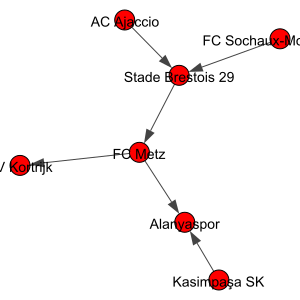

In [101]:
com_22 = Com_data17.subgraph(2)
plot(com_22, vertex_label = labels, bbox=(300, 300))


**Observation**

From the graph we can observe that the community 22 shows the connection between French and Belgian clubs

# <center><font color= green>Network Analysis FIFA 2018</font></center>


**Defining the Vertex and Nodes**

In [102]:
g_data18 = Graph.DataFrame(edges=edges18, vertices=g18, directed=True, use_vids=False)

In [103]:
summary(g_data18)

IGRAPH DNW- 647 1412 -- 
+ attr: age (v), country (v), international_reputation18 (v), league_name18 (v), league_rank18 (v), name (v), nationality (v), num_players (v), overall18 (v), value_eur18 (v), wage_eur18 (v), weight (e)


**Observation**

As the summary indicates, we have created a Directed Named and Weighted graph where we have 572 nodes and 1333 edges for the 2018 futbol transfer market window. As we mentioned previously, the reason why the edges increase year over year is tied to the limitations of matching the naming of clubes in the dataset.

### <center>Network Properties</center>

Reviewing the properties of the 2018 futbol market

In [104]:
Graph.average_path_length(g_data18)

5.826223957689741

In [105]:
# Nodes with maximum distribution:
print("The maximum degree distribution is: ", Graph.maxdegree(g_data18))

The maximum degree distribution is:  21


In [106]:
print("The minimum degree distribution is: ", np.min(g_data18.vs.degree()))

The minimum degree distribution is:  0


In [107]:
# Measure of the "longest shortest path" with weights:
g_data18.diameter(weights = 'weight')

119.0

In [108]:
len(Graph.get_diameter(g_data18))

19

The average path between 2017 and 2018 was marginally reduced while the degrees and diameter increased. 

### <center>Centrality Measures</center>

Obtaining information for the 2017 club centrality. Since the closenness provides inconsistent results we will focus on the harmonic centrality instead.

In [109]:
degree = g_data18.degree()

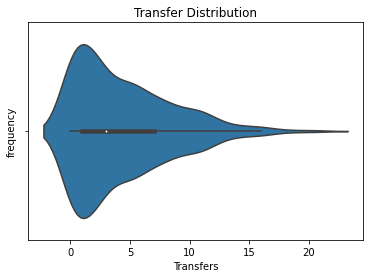

In [110]:
sns.violinplot(degree).set(title='Transfer Distribution', xlabel='Transfers', ylabel='frequency');

In [111]:
v_betweenness = g_data18.vs.betweenness()

In [112]:
v_harmonic = g_data18.harmonic_centrality(normalized = True)

In [113]:
# Centrality Measures 2016
g18['degree'] = degree
g18['betw'] = v_betweenness
g18['harmonic'] = v_harmonic

**Degree Observation**

In 2018, Fiorentina was the team that showed the most number of transfers with a total of 21 - followed closely by Granada who after the poor campaing in 2017 it lost its category. Fiorentina, after finishing close to Europa League positions during the previous season, suffered a mass migration of players that ended up affecting its performance - leaving the team in position 16. That year the team's mood was also strongly hit by the death of their captain - David Astori.

In [114]:
g18.sort_values(by='degree', ascending=False).head(3)

club_name18                league_name18  num_players        age  \
261     Fiorentina              Italian Serie A           31  22.741935   
285     Granada CF     Spanish Segunda División           30  25.166667   
378  Middlesbrough  English League Championship           30  25.133333   

     league_rank18  overall18  value_eur18  wage_eur18  \
261            1.0  71.096774    206080000     1150000   
285            2.0  69.433333     77675000      207000   
378            2.0  68.866667     83885000      350000   

                                           nationality  \
261  Italy, Italy, Italy, Argentina, Italy, France,...   
285  Colombia, Spain, Spain, Venezuela, Spain, Spai...   
378  Denmark, England, England, Benin, Spain, Engla...   

     international_reputation18  country  degree          betw  harmonic  
261                          43    Italy      21   8003.647796  0.272295  
285                          32    Spain      20  12079.659996  0.279261  
378                          33  England      19   8534.283714  0.281793

In [115]:
edges18.loc[edges18['From']=='Fiorentina']

From                   To  weight
short_name                                              
M. Zárate        Fiorentina              Watford     4.0
Borja Valero     Fiorentina                Inter     8.0
S. De Maio       Fiorentina              Bologna     8.0
N. Tomović       Fiorentina        Chievo Verona     8.0
Cristian Tello   Fiorentina           Real Betis     4.0
J. Iličić        Fiorentina             Atalanta     8.0
C. Tătărușanu    Fiorentina            FC Nantes     4.0
F. Bernardeschi  Fiorentina             Juventus     8.0
C. Salcedo       Fiorentina  Eintracht Frankfurt     4.0
M. Vecino        Fiorentina                Inter     8.0
K. Diks          Fiorentina            Feyenoord     4.0

In [116]:
edges18.loc[edges18['To']=='Fiorentina']

From          To  weight
short_name                                          
G. Pezzella           Real Betis  Fiorentina     4.0
R. Saponara               Empoli  Fiorentina     8.0
C. Biraghi               Pescara  Fiorentina     8.0
J. Veretout     AS Saint-Étienne  Fiorentina     4.0
V. Eysseric             OGC Nice  Fiorentina     4.0
V. Laurini                Empoli  Fiorentina     8.0
M. Benassi                Torino  Fiorentina     8.0
M. Sportiello           Atalanta  Fiorentina     8.0
G. Simeone                 Genoa  Fiorentina     8.0
Bruno Gaspar   Vitória Guimarães  Fiorentina     4.0

**Betweenness Observation**

After falling to the Spanish Segunda Division, Granada CF sufferend a mass exit of players - something common in the futbol environment, where due to different reasons such as: loss of financial resources, fan pressure for changes and contract clauses, among others. 

As a result, and following the same dynamic as previous years we can observe Granada having outward edged connecting the team with clubs all across the world.

In [117]:
g18.sort_values(by='betw', ascending=False).head(3)

club_name18               league_name18  num_players        age  \
285   Granada CF    Spanish Segunda División           30  25.166667   
553  Sporting CP  Portuguese Liga ZON SAGRES           30  25.266667   
532   Sevilla FC      Spain Primera Division           27  26.222222   

     league_rank18  overall18  value_eur18  wage_eur18  \
285            2.0  69.433333     77675000      207000   
553            1.0  76.166667    315325000      490000   
532            1.0  77.000000    312000000      504000   

                                           nationality  \
285  Colombia, Spain, Spain, Venezuela, Spain, Spai...   
553  Portugal, Portugal, Netherlands, Portugal, Uru...   
532  Argentina, France, Spain, Italy, Denmark, Fran...   

     international_reputation18   country  degree          betw  harmonic  
285                          32     Spain      20  12079.659996  0.279261  
553                          53  Portugal      13  11621.165076  0.267597  
532                          47     Spain      17   9521.416018  0.271255

In [118]:
edges18.loc[edges18['To']=='Granada CF']

From          To  weight
short_name                                          
A. Ramos       Borussia Dortmund  Granada CF     3.0
Víctor Díaz           CD Leganés  Granada CF     3.0
Montoro            UD Las Palmas  Granada CF     3.0
Álex Martínez         Real Betis  Granada CF     3.0
Quini             Rayo Vallecano  Granada CF     7.0
D. Machís             CD Leganés  Granada CF     3.0
Puertas               UD Almería  Granada CF     7.0

In [119]:
edges18.loc[edges18['From']=='Granada CF']

From                    To  weight
short_name                                                   
G. Ochoa             Granada CF     Standard de Liège     4.0
Oier                 Granada CF            Levante UD     8.0
M. Carcela-González  Granada CF        Olympiacos CFP     4.0
Gabriel Silva        Granada CF      AS Saint-Étienne     4.0
D. Foulquier         Granada CF  RC Strasbourg Alsace     4.0
Jon Toral            Granada CF             Hull City     3.0
Luís Martins         Granada CF  Clube Sport Marítimo     4.0
Sergi Samper         Granada CF         UD Las Palmas     8.0
Andreas Pereira      Granada CF           Valencia CF     8.0
Rúben Vezo           Granada CF           Valencia CF     8.0
C. Aboagye           Granada CF            Club Atlas     4.0
G. Silva             Granada CF         Independiente     4.0
Pol Llonch           Granada CF          Wisła Kraków     4.0

**Harmonic Closeness Observation**

In 2018, Middlesbrough was the club with the highest closeness centrality as the club managed to connect with several second division and first division clubs from different clubs across Europe.

In [120]:
g18.sort_values(by='harmonic', ascending=False).head(3)

club_name18                league_name18  num_players        age  \
378  Middlesbrough  English League Championship           30  25.133333   
285     Granada CF     Spanish Segunda División           30  25.166667   
466     Real Betis       Spain Primera Division           24  25.416667   

     league_rank18  overall18  value_eur18  wage_eur18  \
378            2.0  68.866667     83885000      350000   
285            2.0  69.433333     77675000      207000   
466            1.0  73.458333    167025000      426000   

                                           nationality  \
378  Denmark, England, England, Benin, Spain, Engla...   
285  Colombia, Spain, Spain, Venezuela, Spain, Spai...   
466  Algeria, Spain, Mexico, Paraguay, Algeria, Spa...   

     international_reputation18  country  degree          betw  harmonic  
378                          33  England      19   8534.283714  0.281793  
285                          32    Spain      20  12079.659996  0.279261  
466                          34    Spain      16   9042.552700  0.273739

In [121]:
edges18.loc[edges18['To']=='Middlesbrough']

From             To  weight
short_name                                                    
D. Randolph             West Ham United  Middlesbrough     3.0
J. Howson                  Norwich City  Middlesbrough     7.0
M. Braithwaite   Toulouse Football Club  Middlesbrough     3.0
C. Christie                Derby County  Middlesbrough     7.0
B. Assombalonga       Nottingham Forest  Middlesbrough     7.0
P. Bamford                      Burnley  Middlesbrough     3.0
L. Baker                        Vitesse  Middlesbrough     3.0

In [122]:
edges18.loc[edges18['From']=='Middlesbrough']

From                   To  weight
short_name                                             
D. Nugent    Middlesbrough         Derby County     3.0
B. Guzan     Middlesbrough       Atlanta United     4.0
J. Rhodes    Middlesbrough  Sheffield Wednesday     3.0
B. Espinosa  Middlesbrough            Girona FC     4.0
C. Stuani    Middlesbrough            Girona FC     4.0
G. Ramírez   Middlesbrough            Sampdoria     4.0
V. Fischer   Middlesbrough      1. FSV Mainz 05     4.0
J. Husband   Middlesbrough         Norwich City     3.0
C. Chambers  Middlesbrough              Arsenal     8.0
M. de Roon   Middlesbrough             Atalanta     4.0
B. Morris    Middlesbrough           Shrewsbury     3.0
J. De Sart   Middlesbrough     SV Zulte-Waregem     4.0

### <center>Community Detection</center>

Looking at the communities created in the 2016/17 market.

In [123]:
Com_data=g_data18.community_infomap(edge_weights='weight')

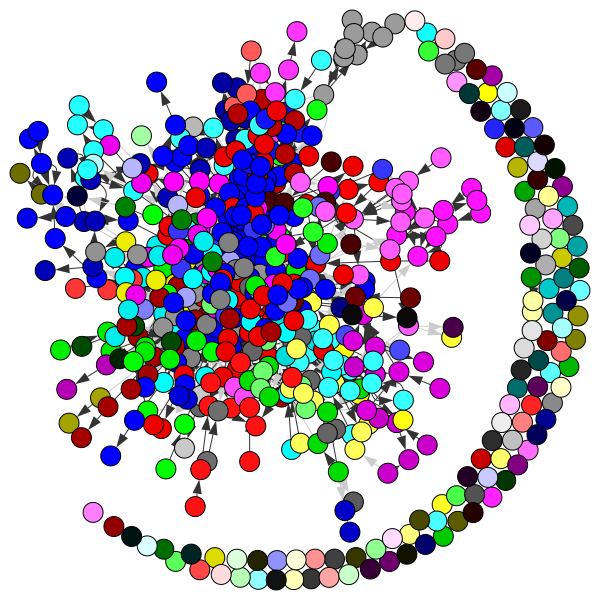

In [124]:
plot(Com_data)

In [125]:
for club in Com_data[12][:]:
    print(g_data18.vs[club]['league_name18'],'- Team:',g_data18.vs[club]['name'],'Reputation:',
          g_data18.vs[club]['international_reputation18'])

Danish Superliga - Team: Aalborg BK Reputation: 28
Turkish Süper Lig - Team: Antalyaspor Reputation: 39
Danish Superliga - Team: FC Nordsjælland Reputation: 27
Turkish Süper Lig - Team: Galatasaray SK Reputation: 46
Turkish Süper Lig - Team: Gençlerbirliği SK Reputation: 30
Japanese J. League Division 1 - Team: Kashiwa Reysol Reputation: 28
Turkish Süper Lig - Team: Osmanlıspor Reputation: 26
French Ligue 1 - Team: Stade Rennais FC Reputation: 40
Japanese J. League Division 1 - Team: Vissel Kobe Reputation: 32


In [126]:
labels = []
for club in Com_data[12][:]:
    labels.append(g_data18.vs[club]['name'])

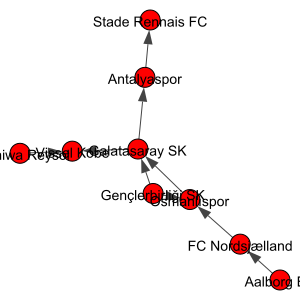

In [127]:
com_10 =Com_data.subgraph(12)
plot(com_10, vertex_label = labels, bbox=(300, 300))


**Observation**

From the graph we can can observe an interesting community between mainly turkish clubs (and some Danish/Japanese clubs) where we can see an interesting tryiad formed between Galatasaray, Gençlerbirliği and Osmanlıspor

# <center><font color= green>Network Analysis FIFA 2019</font></center>


**Defining the Vertex and Nodes**

In [128]:
g_data19 = Graph.DataFrame(edges=edges19, vertices=g19, directed=True, use_vids=False)

In [129]:
summary(g_data19)

IGRAPH DNW- 651 1188 -- 
+ attr: age (v), country (v), international_reputation19 (v), league_name19 (v), league_rank19 (v), name (v), nationality (v), num_players (v), overall19 (v), value_eur19 (v), wage_eur19 (v), weight (e)


**Observation**

As the summary indicates, we have created a Directed Named and Weighted graph where we have 589 nodes and 1132 edges for the 2019 futbol transfer market window.

### <center>Network Properties</center>

Reviewing the properties of the 2019 futbol market

In [130]:
Graph.average_path_length(g_data19)

6.338568467436838

In [131]:
# Nodes with maximum distribution:
print("The maximum degree distribution is: ", Graph.maxdegree(g_data19))

The maximum degree distribution is:  20


In [132]:
print("The minimum degree distribution is: ", np.min(g_data19.vs.degree()))

The minimum degree distribution is:  0


In [133]:
# Measure of the "longest shortest path" with weights:
g_data19.diameter(weights = 'weight')

103.0

In [134]:
len(Graph.get_diameter(g_data19))

20

The average path increased in contrast to 2018, while the diameter remained unchanged.

### <center>Centrality Measures</center>

Obtaining information for the 2017 club centrality. Since the closenness provides inconsistent results we will focus on the harmonic centrality instead.

In [135]:
degree = g_data19.degree()

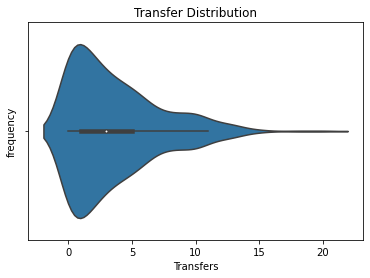

In [136]:
sns.violinplot(degree).set(title='Transfer Distribution', xlabel='Transfers', ylabel='frequency');

In [137]:
v_betweenness = g_data19.vs.betweenness()

In [138]:
v_harmonic = g_data19.harmonic_centrality(normalized = True)

In [139]:
# Centrality Measures 2016
g19['degree'] = degree
g19['betw'] = v_betweenness
g19['harmonic'] = v_harmonic

**Degree Observation**

In 2019, Fulham was the most active team in the market with 20 transfers. An action that led the team to lose its category.

In [140]:
g19.sort_values(by='degree', ascending=False).head(3)

club_name19             league_name19  num_players        age  \
259         Fulham    English Premier League           33  23.878788   
591  UD Las Palmas  Spanish Segunda División           30  26.666667   
132        Chelsea    English Premier League           33  25.878788   

     league_rank19  overall19  value_eur19  wage_eur19  \
259            1.0  70.636364    190670000     1080000   
591            2.0  69.366667     60925000      182000   
132            1.0  78.666667    646135000     3367000   

                                           nationality  \
259  Ivory Coast, Spain, Spain, Scotland, Germany, ...   
591  Spain, Argentina, Argentina, Spain, Spain, Spa...   
132  Belgium, France, Spain, Italy, Spain, Brazil, ...   

     international_reputation19  country  degree          betw  harmonic  
259                          39  England      20  14236.467564  0.267647  
591                          32    Spain      18   9540.127326  0.250264  
132                          70  England      15   7019.868663  0.256544

In [141]:
edges19.loc[edges19['From']=='Fulham']

From                       To  weight
short_name                                            
M. Madl        Fulham          FK Austria Wien     4.0
D. Button      Fulham   Brighton & Hove Albion     4.0
O. Norwood     Fulham         Sheffield United     7.0
J. Graham      Fulham  Wolverhampton Wanderers     4.0
Lucas Piazón   Fulham                  Chelsea     4.0
G. Williams    Fulham      Forest Green Rovers     1.0
S. Kavanagh    Fulham          Shamrock Rovers     4.0
Marcelo Djaló  Fulham           Extremadura UD     3.0
S. Ojo         Fulham                Liverpool     4.0

In [142]:
edges19.loc[edges19['To']=='Fulham']

From      To  weight
short_name                                      
Fabricio             Beşiktaş JK  Fulham     4.0
M. Le Marchand          OGC Nice  Fulham     4.0
C. Christie        Middlesbrough  Fulham     4.0
J. Bryan            Bristol City  Fulham     4.0
C. Woodrow          Bristol City  Fulham     4.0
C. Chambers              Arsenal  Fulham     8.0
Sergio Rico           Sevilla FC  Fulham     4.0
L. Vietto        Atlético Madrid  Fulham     4.0
A. Mawson           Swansea City  Fulham     8.0
A. Mitrović     Newcastle United  Fulham     8.0
J. Seri                 OGC Nice  Fulham     4.0

**Betweenness Observation**

With 20 transfers, Fulham managed to connect with most of the different futbol leagues - allowing this club to lie in the shortest path of the different groups/transfers.

In [143]:
g19.sort_values(by='betw', ascending=False).head(3)

club_name19           league_name19  num_players        age  \
259                   Fulham  English Premier League           33  23.878788   
640  Wolverhampton Wanderers  English Premier League           33  24.242424   
416           Olympiacos CFP      Greek Super League           28  25.000000   

     league_rank19  overall19  value_eur19  wage_eur19  \
259            1.0  70.636364    190670000     1080000   
640            1.0  71.090909    178925000     1153000   
416            1.0  72.214286    126500000       34500   

                                           nationality  \
259  Ivory Coast, Spain, Spain, Scotland, Germany, ...   
640  Portugal, Portugal, Portugal, Spain, Portugal,...   
416  Portugal, Israel, Greece, Greece, Greece, Egyp...   

     international_reputation19  country  degree          betw  harmonic  
259                          39  England      20  14236.467564  0.267647  
640                          44  England      15  11864.303252  0.262324  
416                          33   Greece      13  10118.999447  0.247342

**Harmonic Closeness Observation**

In 2019, and following a trend of most of the previous years, Fulham - an english team - is set as the most central team (regarding transfers connections).

In [144]:
g19.sort_values(by='harmonic', ascending=False).head(3)

club_name19           league_name19  num_players        age  \
259                   Fulham  English Premier League           33  23.878788   
640  Wolverhampton Wanderers  English Premier League           33  24.242424   
132                  Chelsea  English Premier League           33  25.878788   

     league_rank19  overall19  value_eur19  wage_eur19  \
259            1.0  70.636364    190670000     1080000   
640            1.0  71.090909    178925000     1153000   
132            1.0  78.666667    646135000     3367000   

                                           nationality  \
259  Ivory Coast, Spain, Spain, Scotland, Germany, ...   
640  Portugal, Portugal, Portugal, Spain, Portugal,...   
132  Belgium, France, Spain, Italy, Spain, Brazil, ...   

     international_reputation19  country  degree          betw  harmonic  
259                          39  England      20  14236.467564  0.267647  
640                          44  England      15  11864.303252  0.262324  
132                          70  England      15   7019.868663  0.256544

### <center>Community Detection</center>

Looking at the communities created in the 2016/17 market.

In [145]:
Com_data=g_data19.community_infomap(edge_weights='weight')

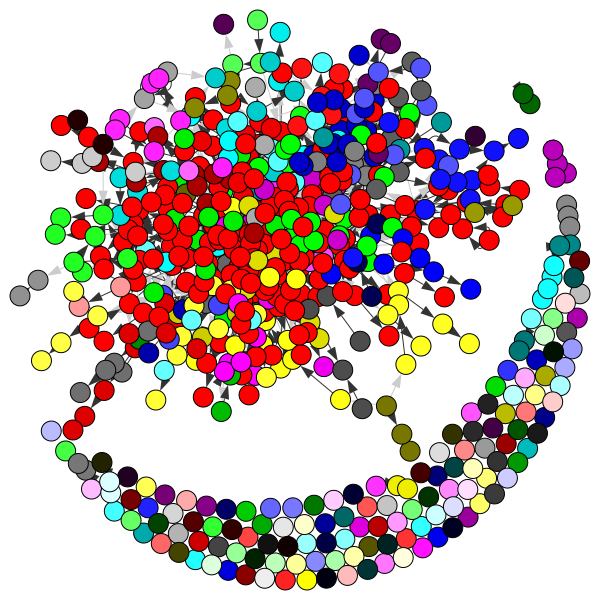

In [146]:
plot(Com_data)

In [214]:
for club in Com_data[11][:]:
    print(g_data19.vs[club]['league_name19'],'- Team:',g_data19.vs[club]['name'],'Reputation:',
          g_data19.vs[club]['international_reputation19'])

French Ligue 2 - Team: AJ Auxerre Reputation: 30
Italian Serie A - Team: Atalanta Reputation: 40
Mexican Liga MX - Team: Club Atlas Reputation: 29
Argentina Primera División - Team: Club Atlético Lanús Reputation: 28
Mexican Liga MX - Team: Club Necaxa Reputation: 31
Holland Eredivisie - Team: Excelsior Reputation: 24
Norwegian Eliteserien - Team: IK Start Reputation: 24
USA Major League Soccer - Team: Portland Timbers Reputation: 31
Argentina Primera División - Team: San Martin de Tucumán Reputation: 29


In [215]:
labels = []
for club in Com_data[11][:]:
    labels.append(g_data19.vs[club]['name'])

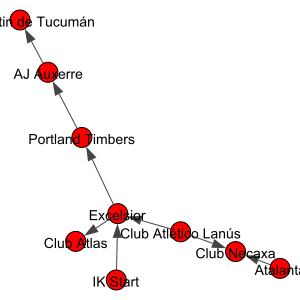

In [216]:
com_10 =Com_data.subgraph(11)
plot(com_10, vertex_label = labels, bbox=(300, 300))


An odd community connecting several clubs from different leagues with Fiorentina- as the receiving node connecting the low-end flow with the top flow.

# <center><font color= green>Network Analysis FIFA 2020</font></center>


**Defining the Vertex and Nodes**

In [150]:
g_data20 = Graph.DataFrame(edges=edges20, vertices=g20, directed=True, use_vids=False)

In [151]:
summary(g_data20)

IGRAPH DNW- 668 1185 -- 
+ attr: age (v), country (v), international_reputation20 (v), league_name20 (v), league_rank20 (v), name (v), nationality (v), num_players (v), overall20 (v), value_eur20 (v), wage_eur20 (v), weight (e)


**Observation**

As the summary indicates, we have created a Directed Named and Weighted graph where we have 588 nodes and 1111 edges for the year 2020.

### <center>Network Properties</center>

Reviewing the properties of the 2020 futbol market

In [152]:
Graph.average_path_length(g_data20)

6.791967021581465

In [153]:
# Nodes with maximum distribution:
print("The maximum degree distribution is: ", Graph.maxdegree(g_data20))

The maximum degree distribution is:  17


In [154]:
print("The minimum degree distribution is: ", np.min(g_data18.vs.degree()))

The minimum degree distribution is:  0


In [155]:
# Measure of the "longest shortest path" with weights:
g_data20.diameter(weights = 'weight')

112.0

In [156]:
len(Graph.get_diameter(g_data20))

23

The degree distribution fell from 2019 to 2020, while the diameter of the network increased.

### <center>Centrality Measures</center>

Obtaining information for the 2020 centrality measures

In [157]:
degree = g_data20.degree()

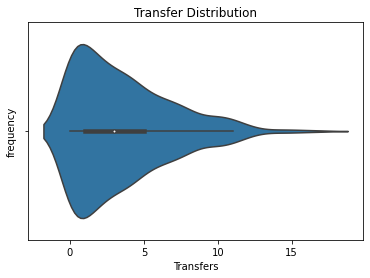

In [158]:
sns.violinplot(degree).set(title='Transfer Distribution', xlabel='Transfers', ylabel='frequency');

In [159]:
v_betweenness = g_data20.vs.betweenness()

In [160]:
v_harmonic = g_data20.harmonic_centrality(normalized = True)

In [161]:
# Centrality Measures 2016
g20['degree'] = degree
g20['betw'] = v_betweenness
g20['harmonic'] = v_harmonic

**Degree Observation**

Stoke City is a team that, while having a history playing for the English Premier League, has for some years playing for second division (English Championship) with a mediocre performance. This aspect could have motivated a strong renewal of the squad, with most of the edges flowing inwards to Stoke City. 

In [162]:
g20.sort_values(by='degree', ascending=False).head(3)

club_name20                league_name20  num_players        age  \
582     Stoke City  English League Championship           30  26.766667   
260  Fenerbahçe SK            Turkish Süper Lig           30  26.500000   
545     Sevilla FC       Spain Primera Division           33  25.151515   

     league_rank20  overall20  value_eur20  wage_eur20  \
582            2.0  71.066667     92650000      602000   
260            1.0  72.266667    155575000     1180000   
545            1.0  75.424242    333150000      482000   

                                           nationality  \
582  England, Senegal, France, Wales, Austria, Wale...   
260  Germany, Turkey, Nigeria, Turkey, Mexico, Denm...   
545  Argentina, Spain, Denmark, Netherlands, Czech ...   

     international_reputation20  country  degree          betw  harmonic  
582                          38  England      17   6717.631666  0.236170  
260                          41   Turkey      16  10844.571167  0.244494  
545                          54    Spain      15  24512.805664  0.254087

In [163]:
edges20.loc[edges20['From']=='Stoke City']

From                   To  weight
short_name                                          
Bojan        Stoke City      Montreal Impact     4.0
E. Pieters   Stoke City              Burnley     4.0
G. Cameron   Stoke City  Queens Park Rangers     7.0
B. Afobe     Stoke City         Bristol City     7.0
S. Berahino  Stoke City     SV Zulte-Waregem     4.0

In [164]:
edges20.loc[edges20['To']=='Stoke City']

From          To  weight
short_name                                             
S. Ward                     Burnley  Stoke City     3.0
S. Vokes                    Burnley  Stoke City     3.0
M. Duffy           Sheffield United  Stoke City     7.0
D. Batth    Wolverhampton Wanderers  Stoke City     3.0
A. Davies                  Barnsley  Stoke City     3.0
N. Powell            Wigan Athletic  Stoke City     7.0
J. Cousins      Queens Park Rangers  Stoke City     7.0
T. Smith          Huddersfield Town  Stoke City     3.0
K. Wimmer               Hannover 96  Stoke City     3.0
S. Hogan                Aston Villa  Stoke City     7.0
L. Lindsay                 Barnsley  Stoke City     3.0
L. Gregory                 Millwall  Stoke City     7.0

**Betweenness Observation**

In 2020, the team that showed the highest betweenness was Sevilla due to similar arguments as previous years. Over the past few years Sevilla has consistently managed to build a highly competitive team, managing to obtain in the 2019/2020 the UEFA Europa League. 

This increase in its European presence is also observed in the market where, the club has actively acquired and transfered players to top teams across Europe. 

In [165]:
g20.sort_values(by='betw', ascending=False).head(3)

club_name20           league_name20  num_players        age  \
545  Sevilla FC  Spain Primera Division           33  25.151515   
437         PSV      Holland Eredivisie           30  23.633333   
438     Pachuca         Mexican Liga MX           25  26.160000   

     league_rank20  overall20  value_eur20  wage_eur20  \
545            1.0  75.424242    333150000      482000   
437            1.0  73.566667    238300000      378000   
438            1.0  69.560000     71275000      297000   

                                           nationality  \
545  Argentina, Spain, Denmark, Netherlands, Czech ...   
437  Netherlands, Mexico, Netherlands, Netherlands,...   
438  Mexico, Colombia, Argentina, Argentina, Mexico...   

     international_reputation20      country  degree          betw  harmonic  
545                          54        Spain      15  24512.805664  0.254087  
437                          40  Netherlands       8  14125.166375  0.227886  
438                          27       Mexico       8  11639.576171  0.209789

In [166]:
edges20.loc[edges20['To']=='Sevilla FC']

From          To  weight
short_name                                               
Fernando               Galatasaray SK  Sevilla FC     4.0
L. de Jong                        PSV  Sevilla FC     4.0
L. Ocampos     Olympique de Marseille  Sevilla FC     4.0
Sergio Rico                    Fulham  Sevilla FC     4.0
M. Dabbur        FC Red Bull Salzburg  Sevilla FC     4.0
Óliver Torres                FC Porto  Sevilla FC     4.0
Munir                    FC Barcelona  Sevilla FC     8.0
Joan Jordán                  SD Eibar  Sevilla FC     8.0

In [167]:
edges20.loc[edges20['From']=='Sevilla FC']

From                   To  weight
short_name                                               
Pablo Sarabia     Sevilla FC  Paris Saint-Germain     4.0
L. Muriel         Sevilla FC             Atalanta     4.0
W. Ben Yedder     Sevilla FC            AS Monaco     4.0
Aleix Vidal       Sevilla FC     Deportivo Alavés     8.0
Roque Mesa        Sevilla FC           CD Leganés     8.0
I. Amadou         Sevilla FC         Norwich City     4.0
Carlos Fernández  Sevilla FC           Granada CF     8.0

**Harmonic Closeness Observation**

This central role that Sevilla had in the 2019/20 campaign has also placed the club - in terms of transfers - as the most central club where its connections with interaction with top teams such as PSG, Barcelona, Porto, Olympique de Marseille or Atlanta has set the club at a central position.

In [168]:
g20.sort_values(by='harmonic', ascending=False).head(3)

club_name20                league_name20  num_players        age  \
545         Sevilla FC       Spain Primera Division           33  25.151515   
419  Nottingham Forest  English League Championship           30  27.133333   
260      Fenerbahçe SK            Turkish Süper Lig           30  26.500000   

     league_rank20  overall20  value_eur20  wage_eur20  \
545            1.0  75.424242    333150000      482000   
419            2.0  71.100000     91300000      682000   
260            1.0  72.266667    155575000     1180000   

                                           nationality  \
545  Argentina, Spain, Denmark, Netherlands, Czech ...   
419  Guinea Bissau, England, Portugal, Spain, Mali,...   
260  Germany, Turkey, Nigeria, Turkey, Mexico, Denm...   

     international_reputation20  country  degree          betw  harmonic  
545                          54    Spain      15  24512.805664  0.254087  
419                          34  England      12   6369.718109  0.249065  
260                          41   Turkey      16  10844.571167  0.244494

### <center>Community Detection</center>

Looking at the communities created in the 2019/20 market.

In [169]:
Com_data=g_data20.community_infomap(edge_weights='weight')

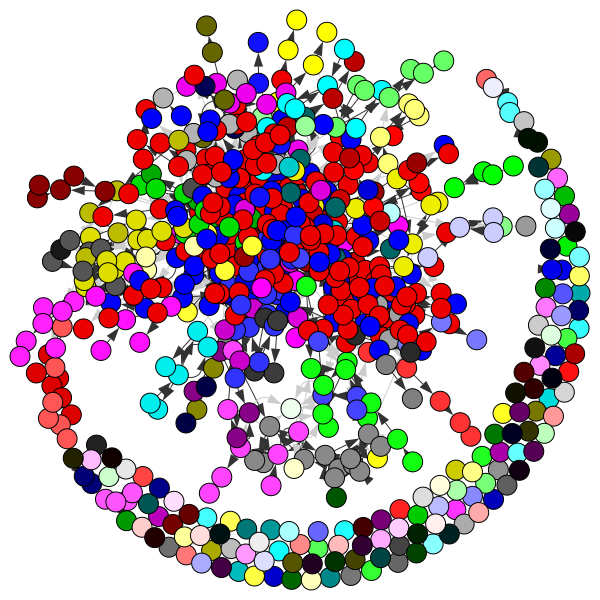

In [170]:
plot(Com_data)

In [171]:
for club in Com_data[1][:]:
    print(g_data20.vs[club]['league_name20'],'- Team:',g_data20.vs[club]['name'],'Reputation:',
          g_data20.vs[club]['international_reputation20'])

German 3. Bundesliga - Team: 1. FC Kaiserslautern Reputation: 28
Danish Superliga - Team: FC Midtjylland Reputation: 27
Danish Superliga - Team: FC Nordsjælland Reputation: 26
Danish Superliga - Team: SønderjyskE Reputation: 27


In [172]:
labels = []
for club in Com_data[1][:]:
    labels.append(g_data20.vs[club]['name'])

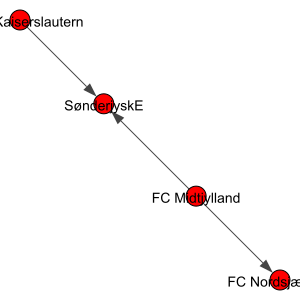

In [173]:
com_1 =Com_data.subgraph(1)
plot(com_1, vertex_label = labels, bbox=(300, 300))


**Observation**

A small linear community connecting mainly clubs from the Danish league can be observed where SonderiyskE only shows inward flow, whereas Midtiylland has an opposite behavior with outflow connections.

# <center><font color= green>Network Analysis FIFA 2021</font></center>


**Defining the Vertex and Nodes**

In [174]:
g_data21 = Graph.DataFrame(edges=edges21, vertices=g21, directed=True, use_vids=False)

In [175]:
summary(g_data21)

IGRAPH DNW- 681 1042 -- 
+ attr: age (v), country (v), international_reputation (v), league_name (v), league_rank (v), name (v), nationality (v), num_players (v), overall (v), value_eur (v), wage_eur (v), weight (e)


**Observation**

As the summary indicates, we have created a Directed Named and Weighted graph where we have 681 nodes and 1042 edges for the 2020/21 futbol transfer market - a strange year due to Covid.

### <center>Network Properties</center>

Reviewing the properties of the 2021 futbol market

In [176]:
Graph.average_path_length(g_data21)

7.303541622962632

In [177]:
# Nodes with maximum distribution:
print("The maximum degree distribution is: ", Graph.maxdegree(g_data21))

The maximum degree distribution is:  14


In [178]:
print("The minimum degree distribution is: ", np.min(g_data21.vs.degree()))

The minimum degree distribution is:  0


In [179]:
# Measure of the "longest shortest path" with weights:
g_data21.diameter(weights = 'weight')

114.0

In [180]:
len(Graph.get_diameter(g_data21))

20

The diameter and path length has sequentially increased - this results should be taken carefully due to the restrictions established earlier on the nodes/edges definition.

### <center>Centrality Measures</center>

Obtaining information for the 2021 club centrality

In [181]:
degree = g_data21.degree()

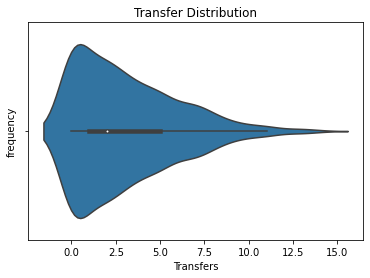

In [182]:
sns.violinplot(degree).set(title='Transfer Distribution', xlabel='Transfers', ylabel='frequency');

In [183]:
v_betweenness = g_data21.vs.betweenness()

In [184]:
v_harmonic = g_data21.harmonic_centrality(normalized = True)

In [185]:
# Centrality Measures 2016
g21['degree'] = degree
g21['betw'] = v_betweenness
g21['harmonic'] = v_harmonic

**Degree Observation**

After winning the Europa League, and in a year where the average degree was way lower than previous years, Sevilla was the club that was most active in the transfer market.

In [186]:
g21.sort_values(by='degree', ascending=False).head(3)

club_name             league_name  num_players        age  \
554             Sevilla FC  Spain Primera Division           33  26.121212   
131                Chelsea  English Premier League           33  25.575758   
390  Medipol Başakşehir FK       Turkish Süper Lig           30  27.633333   

     league_rank    overall  value_eur  wage_eur  \
554          1.0  75.969697  357875000    814000   
131          1.0  79.212121  602275000   2698000   
390          1.0  71.433333  120400000    687000   

                                           nationality  \
554  Spain, Brazil, Brazil, Argentina, Argentina, C...   
131  France, Germany, Germany, Morocco, Brazil, Spa...   
390  Bosnia Herzegovina, Slovakia, Belgium, Brazil,...   

     international_reputation  country  degree          betw  harmonic  
554                        53    Spain      14  13733.232061  0.215317  
131                        66  England      13   9046.385735  0.219984  
390                        41   Turkey      13   7130.298826  0.219014

In [187]:
edges21.loc[edges21['To']=='Sevilla FC']

From          To  weight
short_name                                            
I. Rakitić            FC Barcelona  Sevilla FC     8.0
Aleix Vidal       Deportivo Alavés  Sevilla FC     8.0
Suso                         Milan  Sevilla FC     4.0
Roque Mesa              CD Leganés  Sevilla FC     8.0
Y. Bounou                Girona FC  Sevilla FC     4.0
I. Amadou             Norwich City  Sevilla FC     4.0
Carlos Fernández        Granada CF  Sevilla FC     8.0
M. Acuña               Sporting CP  Sevilla FC     4.0

In [188]:
edges21.loc[edges21['From']=='Sevilla FC']

From                   To  weight
short_name                                             
E. Banega       Sevilla FC            Al Shabab     4.0
S. Kjær         Sevilla FC                Milan     4.0
Daniel Carriço  Sevilla FC           Wuhan Zall     4.0
Nolito          Sevilla FC             RC Celta     8.0
Sergio Rico     Sevilla FC  Paris Saint-Germain     4.0
M. Dabbur       Sevilla FC  TSG 1899 Hoffenheim     4.0

**Betweenness Observation**

Following the general trend observed, the UK is highly interconnected and this leads for teams with a relatively high degree to show a high betweenness. In this case, Bristol City was the team with the highest betweenness for the 2021 transfer market (within FIFA).

In [189]:
g21.sort_values(by='betw', ascending=False).head(3)

club_name                  league_name  num_players        age  \
100  Bristol City  English League Championship           30  25.000000   
276        Fulham       English Premier League           33  24.969697   
373  Lincoln City           English League One           27  21.925926   

     league_rank    overall  value_eur  wage_eur  \
100          2.0  67.900000   51975000    506000   
276          1.0  69.939394  148675000   1616000   
373          3.0  60.111111   10805000     54500   

                                           nationality  \
100  England, Sweden, Hungary, Bermuda, England, Cz...   
276  France, Cameroon, Netherlands, Serbia, Gabon, ...   
373  Scotland, England, England, England, England, ...   

     international_reputation  country  degree          betw  harmonic  
100                        31  England      13  27484.710634  0.216007  
276                        38  England      13  14932.345846  0.226717  
373                        27  England      10  14670.084554  0.195083

In [190]:
edges21.loc[edges21['To']=='Bristol City']

From            To  weight
short_name                                             
C. Brunt     West Bromwich Albion  Bristol City     7.0
C. Martin            Derby County  Bristol City     7.0
J. Paterson          Derby County  Bristol City     7.0
N. Wells      Queens Park Rangers  Bristol City     7.0
A. Mawson                  Fulham  Bristol City     7.0
J. Morrell           Lincoln City  Bristol City     3.0
Z. Vyner                 Aberdeen  Bristol City     3.0

In [191]:
edges21.loc[edges21['From']=='Bristol City']

From                   To  weight
short_name                                             
K. Smith      Bristol City         Swansea City     7.0
M. Watkins    Bristol City             Aberdeen     4.0
B. Wright     Bristol City           Sunderland     3.0
B. Afobe      Bristol City          Trabzonspor     4.0
S. Szmodics   Bristol City  Peterborough United     3.0
J. Brownhill  Bristol City              Burnley     4.0

**Harmonic Closeness Observation**

Fulham, followed by Chelsea, are the teams that had the highest centrality when it comes to transfers. Fulham, decided to move once again into the first division has interacted with powerful European teams from the different leagues. Similarly, Chelsea - with strong competitive ambitions within Europe - built a team that when up to win the UEFA Champions League.

In [192]:
g21.sort_values(by='harmonic', ascending=False).head(3)

club_name             league_name  num_players        age  \
276                 Fulham  English Premier League           33  24.969697   
131                Chelsea  English Premier League           33  25.575758   
390  Medipol Başakşehir FK       Turkish Süper Lig           30  27.633333   

     league_rank    overall  value_eur  wage_eur  \
276          1.0  69.939394  148675000   1616000   
131          1.0  79.212121  602275000   2698000   
390          1.0  71.433333  120400000    687000   

                                           nationality  \
276  France, Cameroon, Netherlands, Serbia, Gabon, ...   
131  France, Germany, Germany, Morocco, Brazil, Spa...   
390  Bosnia Herzegovina, Slovakia, Belgium, Brazil,...   

     international_reputation  country  degree          betw  harmonic  
276                        38  England      13  14932.345846  0.226717  
131                        66  England      13   9046.385735  0.219984  
390                        41   Turkey      13   7130.298826  0.219014

In [193]:
edges21.loc[edges21['From']=='Fulham']

From                 To  weight
short_name                                      
Rui Fonte      Fulham           SC Braga     4.0
H. Arter       Fulham        Bournemouth     7.0
F. Ayité       Fulham  Gençlerbirliği SK     4.0
C. Christie    Fulham  Nottingham Forest     7.0
M. Bettinelli  Fulham      Middlesbrough     7.0
A. Mawson      Fulham       Bristol City     7.0
Marcelo Djaló  Fulham            CD Lugo     3.0

In [194]:
edges21.loc[edges21['To']=='Fulham']

From      To  weight
short_name                                     
A. Areola   Paris Saint-Germain  Fulham     4.0
M. Hector               Chelsea  Fulham     8.0
M. Lemina           Southampton  Fulham     8.0
K. Tete      Olympique Lyonnais  Fulham     4.0
J. Seri          Galatasaray SK  Fulham     4.0
O. Aina                  Torino  Fulham     4.0

### <center>Community Detection</center>

Looking at the communities created in the 2020/21 market.

In [195]:
Com_data=g_data21.community_infomap(edge_weights='weight')

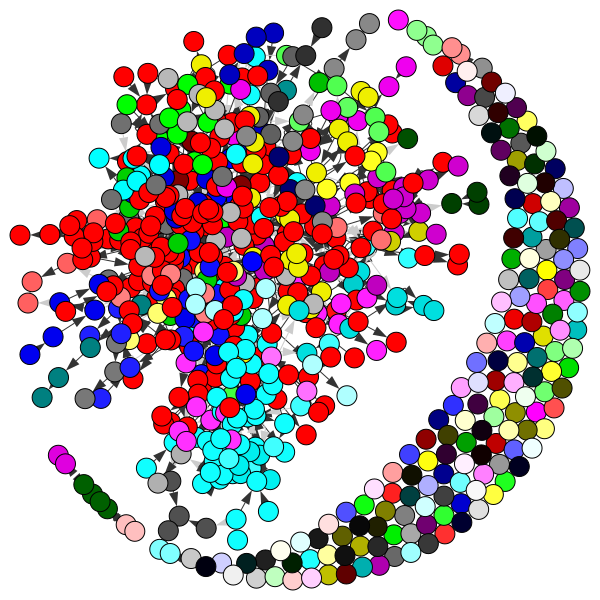

In [196]:
plot(Com_data)

In [197]:
for club in Com_data[2][:]:
    print(g_data21.vs[club]['league_name'],'- Team:',g_data21.vs[club]['name'],'Reputation:',
          g_data21.vs[club]['international_reputation'])

German 1. Bundesliga - Team: 1. FC Köln Reputation: 37
German 1. Bundesliga - Team: 1. FC Union Berlin Reputation: 33
German 1. Bundesliga - Team: Borussia Mönchengladbach Reputation: 48
German 1. Bundesliga - Team: FC Augsburg Reputation: 39
German 1. Bundesliga - Team: Hertha BSC Reputation: 38
German 1. Bundesliga - Team: VfL Wolfsburg Reputation: 40


In [198]:
labels = []
for club in Com_data[2][:]:
    labels.append(g_data21.vs[club]['name'])

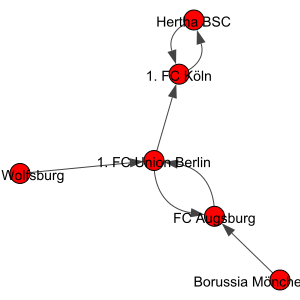

In [199]:
com_22 =Com_data.subgraph(2)
plot(com_22, vertex_label = labels, bbox=(300, 300))


**Observation**

The graph shows an interesting reciprocity occurring in the Bundesliga. 

### General Community observation

As we can observe,the center of the communiity shows an intricate connection in the transfer market where, while the local transfers still have predominance, there is still a high interconnection between different leagues - specially in Europe. Finally, there are some clubs/leagues that are left as satellites, possiblly because they did not participate in the market window and as a result do not connect in this aspect with other clubs.